In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from lieroy import se3

from recov.datasets import KittiDataset
from recova.learning.learning import model_from_file
from recova.registration_result_database import RegistrationPairDatabase

from recova.trajectory_evaluation import collect_trajectory_data, make_cumulative_covariances
from recova.util import set_matplotlibrc

np.set_printoptions(precision=3, linewidth=100)

In [3]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_kitti_02/'
LOCATION = '03'
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/kitti/dataset/sequences/{}'.format(LOCATION)
LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-08-28-kitti-3-4-5.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-08-29-kitti-03.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = KittiDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [4]:
(gt_trajectory, 
 sampled_trajectory,
 cum_covariances, 
 censi_cum_cov) = collect_trajectory_data(db, LOCATION, dataset, learning_dataset['metadata']['descriptor_config'], model)

0
801
  0%|                                                   | 0/800 [00:00<?, ?it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0070677638169432,0.012771140638108197,0.025189232273366682,-0.015512061926666402,-0.0966450868334388,-0.03560721490512928 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.009912329633765,0.008135056202887984,0.022259745047938075,0.014326356849037892,-0.006058641169476234,-0.0039689753318710806 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.006029097971639,0.016656021142341212,0.040528723956012404,0.04606383822476634,0.13408109666990656,-0.0004929193806821148 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0090215776074893,0.01561594994393129,0.04807192563228445,0.019385674147279187,0.08440370481312436,0.01086234753191855 --nopointcloud_log


(100, 6)


0.01 radius
22 outliers
78 inliers


  0%|                                           | 1/800 [00:00<02:33,  5.21it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0104847402602535,0.01013880678502072,0.019100866627571034,0.004582970063326133,-0.02535309849040013,0.0066782804998667955 --nopointcloud_log


(100, 6)


0.01 radius
17 outliers


(100, 6)


83 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001923258255042,0.012778584526737143,0.023898803859177333,-0.0040695050049394275,-0.004170503845696709,0.00511168947141254 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0198897078292546,0.009301385491926998,0.0446136953640422,0.10295021192339573,-0.020823233022058924,0.03316464508224747 --nopointcloud_log


(100, 6)


0.01 radius
20 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9986754127342292,0.009666142041616222,0.02227116992408331,-0.008517488617038382,0.02972954256385454,0.012143916673935731 --nopointcloud_log
80 inliers


  0%|▏                                          | 3/800 [00:00<01:40,  7.96it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0080312298750136,0.009891537970340265,0.021102600935551528,-0.00044294985829070646,0.017384494352254167,0.0041834645624259275 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9924103725935799,0.011057471254156247,0.03674138837792215,0.02942417692633121,-0.032906277691794786,0.011533982514748376 --nopointcloud_log
0.01 radius
21 outliers
79 inliers


  0%|▏                                          | 4/800 [00:00<01:38,  8.10it/s]

0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0037120310595358,0.009645432733425573,0.020150808743788926,0.0009014742988819756,0.00765246648901038,0.005860400365465863 --nopointcloud_log
26 outliers


(100, 6)


74 inliers
0.01 radius
23 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0323445123545854,0.00999216633035427,0.02467361813274048,0.0124473889407105,0.005256844602189022,0.0050344683126285405 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.005641461767708,0.008710550275316373,0.0362636406643227,0.03798401622973653,-0.267963206766402,0.11562164906696233 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9695858771541924,0.007629824368015483,0.032347701866141325,0.008973249522671643,-0.006230286596425167,0.054844636901573256 --nopointcloud_log
0.01 radius
21 outliers
0.01 radius
26 outliers
79 inliers
0.01 radius
28 outliers
72 inliers


  1%|▎                                          | 5/800 [00:00<02:05,  6.34it/s]

74 inliers
0.01 radius
24 outliers
76 inliers


(100, 6)
(100, 6)


0.01 radius
33 outliers
67 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0004064214300215,0.005756012911445921,0.028085893263152913,0.32421307267920885,-0.31977124216209574,0.3768350849943435 --nopointcloud_log


(100, 6)
  1%|▎                                          | 6/800 [00:00<01:58,  6.71it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0051561111996299,0.00798595372746049,0.020023006426975593,-0.07899052226329342,-0.11355761576635702,0.34264678499111684 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0082391253821603,0.008677509029785048,0.039666634674748465,0.18268077876489908,-0.8798974813301464,0.6140213137726865 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0046177985675284,0.008984810036875044,0.018313181144367727,-0.6093855625500145,-0.41959539084769987,0.6687876691991074 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9992921801572259,0.005562016052777951,0.014280861165454559,-0.5585470984391038,-0.023475081298307506,0.6523267064305353 --nopointcloud_log
0.01 radius
22 outliers
78 inliers
0.01 radius
22 outliers
0.01 radius
78 inliers
22 outliers
78 inliers


(100, 6)
  2%|▋                                         | 12/800 [00:01<01:13, 10.66it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0030024928926948,0.003911781011168011,0.016540453820503027,0.215465098833373,0.3821584420143443,0.6237204730458656 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0052883928893406,0.0055062181176667325,0.021626084530360464,-0.04879410731929614,0.10537527914680112,0.10103483526474283 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9947765507421709,0.00433736374636978,0.022487814519110676,-0.06382517282621553,0.12493297198275206,0.5618980014293534 --nopointcloud_log
0.01 radius
49 outliers
51 inliers


(100, 6)


0.01 radius
0.01 radius
51 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9989245675061731,0.0005476855079521628,0.009541807540082516,0.5304006417057349,-0.03185396092853048,0.8227611541384209 --nopointcloud_log
49 inliers
69 outliers
31 inliers
0.01 radius


  2%|▊                                         | 15/800 [00:01<01:10, 11.11it/s]

46 outliers


(100, 6)


54 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0058136217934104,-0.0017494759675334697,0.009198979148539788,0.03012153135987603,-0.10059780943309626,0.25387516716752606 --nopointcloud_log
0.01 radius
65 outliers
35 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0058072962815239,-0.004005835152230028,0.013405384673305126,0.13820475085808223,0.29554078720593596,0.08598550752902707 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0043262925713337,-0.000541273085884654,0.01138419744769437,-0.03708632572104022,0.34721493964136674,0.1855568519939721 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.996719096761046,0.00026571571491859776,0.007320623616178449,-0.0012537882596964274,0.007832510350182158,0.017400902381490075 --nopointcloud_log
0.01 radius
0.01 radius
74 outliers
26 inliers
59 outliers
0.01 radius
41 inliers
66 outliers
34 inliers


(100, 6)
  2%|█                                         | 20/800 [00:01<01:03, 12.28it/s]

0.01 radius


(100, 6)


61 outliers
39 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9973051462775278,-0.0036376733792413602,0.008043646447652363,-0.011538581799718851,-0.027949432123223962,0.017822918764976412 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9952674636562423,-0.00037549663389040014,0.012494760728268382,-0.11888796612296086,-0.3401245873458748,0.16369692634141303 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.002107498487965,-0.0012000685421127543,0.0068044817723932095,-0.06450001428698438,-0.12001283354332233,0.03250718797754722 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9854104637163038,-0.007047824949321184,0.0070711256205529755,-0.008117495677268029,0.03301464208718737,0.01656598051045646 --nopointcloud_log
0.01 radius
45 outliers
55 inliers
0.01 radius
51 outliers
0.01 radius
60 outliers
49 inl

(100, 6)
  3%|█▎                                        | 24/800 [00:01<01:01, 12.61it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9803986261977887,-0.0004271332958364461,0.017260998954418117,-0.01011502638323095,-0.006314856461837025,0.012712035816886643 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8937826849513999,-0.0015309305324473887,0.015290469965944017,0.0018686130594693152,-0.003967122792314926,0.013645047966171567 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.542225095525256,-0.0013864801014859681,0.005255809876583234,-0.002304820135071685,-0.004181887461371521,0.012502353170620132 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3632018241561561,-0.0018483365901806985,-0.002581131755380538,-7.237067209181692e-05,-0.0023601336455665546,0.011278660724104668 --nopointcloud_log
0.01 radius
0.01 radius
35 outliers
23 outliers
65 inliers
0.01 radius
77 inliers
46 outliers


(100, 6)


54 inliers


  4%|█▍                                        | 28/800 [00:02<01:00, 12.78it/s]

0.01 radius
20 outliers
80 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.984937918563772,-0.001764970014815778,0.014522876240984391,0.0008106788045207722,0.03156036972061051,0.023466564859438634 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6100972132702227,0.0018891244108339338,0.013478434646039775,-0.003883684561257619,0.00665737192713708,0.009713370611634159 --nopointcloud_log
24 outliers
76 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.000347064331752,-0.0022938980583588602,0.005194491389899166,0.0016083918695007722,0.005416130832703036,0.00992730902652456 --nopointcloud_log
0.01 radius
28 outliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7091820192721079,0.0065258569928754555,0.017407143615304637,-0.009754358478595642,0.0016557054230771728,0.012774712237851633 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7653281084807181,0.008131064694803233,0.014301339361612823,-0.011006851482640021,-0.0035314877900273394,0.007267809109669318 --nopointcloud_log
72 inliers
26 outliers
74 inliers
0.01 radius
24 outliers
76 inliers


(100, 6)
  4%|█▋                                        | 32/800 [00:02<00:58, 13.12it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8058193773061749,0.007931194146901712,0.011179267393094834,-0.010054810635364389,-0.005420371018462177,0.011271777928345179 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9910564184892179,0.004870241425411554,0.003590609467677192,-0.0037555033074208747,0.012525716841057794,0.013462195905720896 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9935711813448155,0.00294256480707861,0.0034191296143190513,-0.01453270381182147,0.020514420612061005,0.013580380831837779 --nopointcloud_log
0.01 radius
0.01 radius
33 outliers
67 inliers
14 outliers
86 inliers


(100, 6)
(100, 6)


0.01 radius
0.01 radius
23 outliers
31 outliers
0.01 radius
31 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.999002219784599,0.009531608324177607,0.004106165529618989,-0.03874996282626011,-0.024700936496192902,-0.013559819534280346 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0000191458573031,0.010624366930551086,0.014909110340006575,-0.04820378517323935,0.011912838555034415,-0.001475749109228247 --nopointcloud_log
69 inliers
69 inliers


  4%|█▉                                        | 36/800 [00:02<00:57, 13.18it/s](100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9962152350795581,0.004616931604417283,0.003973269883825649,-0.03375256338067393,0.028147689891060357,-0.09002598708242318 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0044010576532592,0.0011478644819231686,-0.0046199033813539535,-0.023518352538479954,-0.04478634484898727,-0.0248771921584954 --nopointcloud_log
0.01 radius
24 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9910454462794414,-0.0001071043901870353,0.0016045014759077311,-0.06487453530080484,-0.29880197871735786,-0.3315117309629874 --nopointcloud_log
76 inliers
0.01 radius


  5%|██▏                                       | 41/800 [00:02<00:53, 14.21it/s]

29 outliers
71 inliers
0.01 radius


(100, 6)


24 outliers
76 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0231380143494488,0.011865602305142378,0.016551541035486877,-0.0720484249418028,0.048073502853572384,-0.052127514982121356 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8862561425752378,0.01184022252497757,0.015618936223623805,-0.017128834174413087,0.015410092062735912,-0.01516227732984489 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9927850179971928,0.012137211913449417,0.01583209373112518,-0.07147723864303687,0.01424969535107485,-0.06432227004350856 --nopointcloud_log
0.01 radius
23 outliers
77 inliers
0.01 radius
0.01 radius
23 outliers
77 inliers


  6%|██▎                                       | 44/800 [00:03<00:54, 13.80it/s]

17 outliers
83 inliers


(100, 6)
(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5669125143295237,0.005697987111078443,0.008701590130679868,-0.02121904795011894,0.013100971882284517,-0.034127026855656106 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9954058791902513,0.010908463788561746,0.012568241678835468,-0.04775805555101539,0.0038417754705297176,-0.0710545006851754 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9045708451399237,0.012131185590692648,0.018624631258592463,-0.056936980154575746,0.020080022503377624,-0.07789430032263099 --nopointcloud_log
14 outliers
26 outliers
86 inliers
74 inliers
0.01 radius


  6%|██▍                                       | 46/800 [00:03<00:55, 13.50it/s]

27 outliers
73 inliers
0.01 radius
28 outliers


(100, 6)


72 inliers
0.01 radius
25 outliers
75 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3644002651132069,0.0035393850343684486,0.008131164980416954,-0.012766659452826918,-0.0012841478433991253,-0.028553219503768344 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.43618043002550977,0.002969133739923642,0.009435664701707069,-0.008293671625529497,0.0018082927457197394,-0.01778234597409947 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5575690566225237,0.006741358862917525,0.0054726113097059124,-0.019155166741284764,-0.00040839124416877545,-0.03342185972671111 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.43500043685446316,0.005840521896297695,0.0032368350932726747,-0.012730056186950663,-0.007567323363604082,-0.023690197096895103 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3078104721640084,0.0026572210146437497,0.006090295448987915,-0.006976900005683979,-0.012509109555311936,-0.03592490054477158 --nopointcloud_log
0.01 radius
31 outliers
69 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.34739672416404765,0.0005758962296598671,0.006372961316418009,-0.0015320450065758524,0.00326215785955081,-0.030317395343285095 --nopointcloud_log
23 outliers
77 inliers


  6%|██▋                                       | 52/800 [00:03<00:53, 13.89it/s]

0.01 radius
21 outliers


(100, 6)


79 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2828577783590229,-0.0024636175836460186,0.005728123859443021,0.0017743657178475936,0.006066039058588605,-0.025611733881513752 --nopointcloud_log
31 outliers
69 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.24397733974083777,-0.0009630185533118333,0.004052605265921301,-0.004591868504905243,0.0036201932928283313,-0.021490458041680018 --nopointcloud_log
0.01 radius
24 outliers
76 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2704964411798885,0.0016376918153647646,0.004522613408484166,-0.010337998703381647,0.0015793162037094973,-0.028108326792803437 --nopointcloud_log
0.01 radius
35 outliers
0.01 radius
26 outliers
74 inliers
65 inliers


  7%|██▉                                       | 56/800 [00:03<00:52, 14.15it/s]

0.01 radius
30 outliers
70 inliers


(100, 6)
(100, 6)


0.01 radius
38 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1969005897169273,0.00044130558627621694,0.006046871078794962,-0.011578925432137807,0.002627158259683002,-0.02968818310178207 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.21348229226228121,0.0027687865520792114,0.004923595065718001,-0.01303408683596656,0.00029926682520463587,-0.024361003740232662 --nopointcloud_log
62 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.17777879277923014,-0.003631754029829449,0.008616354247403257,0.0018996026647637063,0.0034886664428596414,-0.030632050900130943 --nopointcloud_log


  8%|███▏                                      | 60/800 [00:04<00:50, 14.65it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.18988015595283134,-0.004558481610321272,0.0077642365591846065,0.0038957960430847007,-0.00360512611892543,-0.03271696257817827 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.17291662424973012,-0.004328807924337904,0.0056345297949807974,0.005105608866696746,-0.010792953215073191,-0.034470633993134416 --nopointcloud_log
0.01 radius
34 outliers
66 inliers
0.01 radius
0.01 radius
32 outliers


(100, 6)


28 outliers
72 inliers
68 inliers


  8%|███▎                                      | 63/800 [00:04<00:50, 14.51it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1465988964995829,-0.003312149345496663,0.0036722809379111467,-0.0012756437821371577,-0.009997690429215627,-0.04074786025425464 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.16057918544000416,-0.002172382328843595,0.004825796463042265,-0.004825581775710762,-0.0024907190504993024,-0.04917362646314162 --nopointcloud_log
0.01 radius
0.01 radius
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.16826057351722162,-0.0030067934657001926,0.0036822139798950116,-0.004755239503310217,5.406492200850706e-05,-0.04569031015708726 --nopointcloud_log
29 outliers
32 outliers
35 outliers
68 inliers
65 inliers
71 inliers


  8%|███▍                                      | 65/800 [00:04<00:50, 14.49it/s](100, 6)


0.01 radius


(100, 6)
(100, 6)


40 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1326202761882691,-0.005650045874888432,0.0023197209310872563,0.0025558515504802855,0.0005674585569856347,-0.05020914990471615 --nopointcloud_log
60 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.14869951122428987,-0.006798899545855386,0.002719444315437304,0.0030816081735635685,0.0033922076932454254,-0.06398101563145704 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1481487981889332,-0.004434940175357387,0.0031964468793666827,-0.0006955276255213589,-1.7175357833947141e-06,-0.054474617284057225 --nopointcloud_log
0.01 radius
40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.14682405240294036,-0.005921179606781368,0.002045715518568525,-0.000829163642818689,0.0006073750817350189,-0.05869426861815023 --nopointcloud_log


  8%|███▌                                      | 67/800 [00:04<00:50, 14.39it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1766275266844865,-0.006059696245076855,0.002155203080154665,-0.005812115811896623,-0.0027387498039338643,-0.07613245313834759 --nopointcloud_log
0.01 radius
39 outliers
61 inliers
0.01 radius
37 outliers
63 inliers


(100, 6)
  9%|███▌                                      | 69/800 [00:04<00:50, 14.35it/s]

0.01 radius
0.01 radius
36 outliers


(100, 6)


45 outliers
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.22064030560811054,-0.01007375166806544,0.004162561234608598,-0.004626402667775561,0.003417452147553407,-0.09512909846500076 --nopointcloud_log
55 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.17999638136703702,-0.007570207196793091,0.0026318411706765825,-0.0033547089527422654,-0.001394066699874692,-0.08397612893497645 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.22958949624731795,-0.009569547205294363,0.005575582842812849,-0.007814549424344001,0.0035578363453770624,-0.09050142244423934 --nopointcloud_log
0.01 radius
48 outliers
52 inliers


  9%|███▊                                      | 73/800 [00:05<00:49, 14.56it/s](100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.21345876188853297,-0.012919743860770135,0.005336717950645608,-0.0018747850427211765,0.0031005505080454496,-0.08064531605372513 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.24136688906019846,-0.00910383868598531,0.005301609425360988,-0.012894390180397954,0.005009490915503233,-0.1138604853929585 --nopointcloud_log
0.01 radius
45 outliers
55 inliers
43 outliers
57 inliers


  9%|███▉                                      | 75/800 [00:05<00:49, 14.62it/s](100, 6)


0.01 radius
39 outliers
61 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.24828506978817116,-0.02151025386418614,0.004173260499034872,0.010357261612918884,0.0024947786389727215,-0.14781058610623307 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
42 outliers
58 inliers
38 outliers


(100, 6)
 10%|████                                      | 77/800 [00:05<00:49, 14.72it/s]

62 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3027822243983492,-0.02999274364398096,0.002873052084019876,0.025783892786865045,-0.000675826997212559,-0.2693243606866328 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2555594071413772,-0.02314277209727337,0.001211601938877437,0.004962209454492526,-0.004680045947985515,-0.10977069212014398 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3860662444356783,-0.03290058371011634,0.00016750306306915949,-0.0009935040574969168,-0.009150053343161376,-0.15305372189186747 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.26608829203412776,-0.020518193991132326,-0.0001638681809747516,-0.003474924278196874,-0.005288533937860453,-0.1433477187415643 --nopointcloud_log
40 outliers
60 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.27720075516021603,-0.018659357236566837,-4.01289500265536e-05,-0.0072526661731170065,-0.0017944998020443977,-0.12018930751735477 --nopointcloud_log
31 outliers
69 inliers


(100, 6)


0.01 radius
36 outliers
64 inliers


 10%|████▏                                     | 79/800 [00:05<00:50, 14.25it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.41404441488930815,-0.027618545362900926,0.0031960846274488018,-0.013599732311281316,0.0012742137977959278,-0.12983778853149927 --nopointcloud_log
0.01 radius
0.01 radius


(100, 6)


27 outliers
73 inliers
46 outliers
54 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.45805745580997564,-0.023365292000927775,0.002363501133486953,-0.02064654089399983,0.002380518011012036,-0.17787236328857456 --nopointcloud_log


 10%|████▎                                     | 83/800 [00:05<00:48, 14.69it/s]

0.01 radius


(100, 6)
(100, 6)


0.01 radius
43 outliers
38 outliers
62 inliers
0.01 radius
57 inliers
36 outliers
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4269524991518692,-0.043096969257587804,-0.006866012635132708,0.003698919476484529,0.012772237239311236,-0.19825594316511524 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4401123857591842,-0.03135913110722679,0.0012441279784636498,-0.006566611466517821,0.004861926318972221,-0.21323849889335675 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.65124941342662,-0.06654436616287791,-0.0351595476587041,0.002842452485758756,0.009428691561779334,-0.22658755039668016 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3598771834280831,-0.031549423190729384,-0.024693049000585363,0.0025649567060105206,0.0012372043470999152,-0.15863737214279552 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.43422065585457,-0.04301430296392959,-0.018400183833531432,-0.002050868714536403,0.006563966215904217,-0.19888656657551385 --nopointcloud_log
0.01 radius
48 outliers
50 outliers
50 inliers
52 inliers


 11%|████▌                                     | 87/800 [00:05<00:48, 14.80it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4450561781545102,-0.03759282166520717,-0.020788630449690267,-0.003568493867909036,0.013281618201656643,-0.19442449526440334 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.35904376017610923,-0.027837461761469225,-0.015394853015909414,-0.0011857750805963445,0.00860352917524425,-0.20200888653384966 --nopointcloud_log
0.01 radius
37 outliers
63 inliers
0.01 radius
41 outliers


(100, 6)


59 inliers
0.01 radius
40 outliers
60 inliers


 11%|████▋                                     | 90/800 [00:06<00:48, 14.65it/s]

0.01 radius
38 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.46085739866397607,-0.04081452859507936,-0.0012175171844070432,-0.012112072520025363,0.01799438820604578,-0.22809401922003272 --nopointcloud_log


(100, 6)


62 inliers
0.01 radius


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.37210537788673265,-0.02633207795817576,-0.0027992116759193125,-0.02438865112331412,0.014380661671845167,-0.22419510394909567 --nopointcloud_log


(100, 6)


53 outliers
50 outliers
50 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3880651983047362,-0.037102340271918464,-0.0038314968921984317,-0.00011149461068495436,-0.0005148046321996522,-0.20170452407056014 --nopointcloud_log
47 inliers


 12%|████▉                                     | 93/800 [00:06<00:47, 14.90it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.39266180516956867,-0.04000393326780344,0.0006564726818322464,0.030421074040866344,0.010542856636153407,-0.19061114804314627 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.36251654807444794,-0.04244694159848482,0.00025012568244783167,0.03723734130634084,0.010896920863774527,-0.15201454482726542 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4404306310899876,-0.03974292476729505,-0.003845132064745312,0.02323260791393524,0.0031241315969013526,-0.1629038022334422 --nopointcloud_log
0.01 radius
38 outliers
0.01 radius
43 outliers
57 inliers
62 inliers


 12%|█████                                     | 96/800 [00:06<00:47, 14.97it/s](100, 6)


0.01 radius
37 outliers
63 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.46377723066815807,-0.03638886683801335,0.007593500641103184,0.023212223779520733,-0.0008782731830394985,-0.10947363585890879 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3947063867681763,-0.02827909293315457,-0.0024179725982362457,0.005606230483775661,-0.00832783199285254,-0.11717705730312479 --nopointcloud_log


 12%|█████▏                                    | 98/800 [00:06<00:47, 14.92it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5196900514754353,-0.025154663224399444,0.015082659211900995,0.014993540880246578,0.00508949192913238,-0.09006753288742333 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5226158750196863,-0.02278628677064082,0.006383668787423216,0.02141052244184594,0.008489680795624814,-0.09983137118706456 --nopointcloud_log
0.01 radius
0.01 radius
38 outliers
38 outliers
0.01 radius
62 inliers
49 outliers
62 inliers
51 inliers


(100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3984153924702119,-0.00980068531231998,0.0068522572387249,0.018712329311883734,-0.0008425567970221636,-0.08653794069805101 --nopointcloud_log
43 outliers
57 inliers
0.01 radius


(100, 6)


35 outliers


 12%|█████▏                                   | 100/800 [00:06<00:47, 14.70it/s]

65 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.45596740168724526,-0.009506489007121229,0.00768390998587514,0.006894141384448849,-0.005075191542399286,-0.047483390312980454 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
30 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4940643818634947,-0.0039868975844948975,0.007673378736129766,-0.0006220231583340406,0.0018776109105679052,-0.04183688333765654 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6575144390973757,-0.006832339876381228,0.021060198382229594,0.021205824027596184,-0.016380922500860397,-0.044458866909980195 --nopointcloud_log
70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.47417091279379514,0.002585362208876192,0.01041937512897055,-0.0010910481370387268,-0.002105246122985779,-0.04347483623363286 --nopointcloud_log


(100, 6)


0.01 radius
41 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4334561289298572,-0.013335781322460038,0.01472017900635209,0.021728458417366363,-0.009322327230687273,-0.03498050022787683 --nopointcloud_log
0.01 radius
42 outliers
59 inliers
58 inliers


 13%|█████▎                                   | 103/800 [00:07<00:47, 14.67it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.46393649206492343,-0.006468192150374559,0.007327480210793929,-0.00040277810350377663,0.004524801910645412,-0.02235528266845407 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8869330781846846,0.001060385377801041,0.012564068301511615,-0.011326937443112771,0.010235758175301366,-0.015605571634431067 --nopointcloud_log
0.01 radius
40 outliers
0.01 radius
60 inliers
40 outliers


 13%|█████▍                                   | 107/800 [00:07<00:46, 14.89it/s]

60 inliers


(100, 6)


0.01 radius
32 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.45803374117701534,-0.0016814102532248525,0.011028962123720424,-0.007115278846131498,0.022429643416675762,-0.006979052558406755 --nopointcloud_log


(100, 6)


68 inliers
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8076249862969896,-0.015837389992845348,0.01774306129588324,0.007220837753960545,0.03239417196615199,-0.007332299476923066 --nopointcloud_log
31 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9968988150875526,-0.0264953461375357,0.02521956977411368,0.02270332916288599,0.01928663909594707,-0.004865631975537485 --nopointcloud_log
69 inliers


 14%|█████▋                                   | 110/800 [00:07<00:46, 14.92it/s](100, 6)


0.01 radius
36 outliers
0.01 radius
34 outliers
66 inliers
0.01 radius
32 outliers
0.01 radius
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9922423852995845,-0.019978378260251218,0.026106815611528528,0.024597058574764467,-0.017606656894073335,0.0010747094770639177 --nopointcloud_log
31 outliers
69 inliers
68 inliers


 14%|█████▋                                   | 112/800 [00:07<00:45, 14.98it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.002043638406446,-0.009509837861342378,-0.004972712053796497,0.01677619636785219,-0.015923887513096553,0.022858017016869132 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001174334111917,-0.00882248447545477,0.004316616256880734,-0.006193248816963371,0.03132101481694061,0.013559606149031673 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9950057244580133,-0.011199786127002481,-0.0058013180995375325,0.028440649861493326,-0.2978901409770225,0.07836860256642533 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7724713529998813,-0.014686390752381762,0.007856494469780127,0.003986352002902156,-0.025440808335535334,0.0016214083325681512 --nopointcloud_log
26 outliers
74 inliers


 14%|█████▉                                   | 115/800 [00:07<00:45, 15.05it/s]

0.01 radius
28 outliers


(100, 6)


72 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.000985665371232,-0.006925663459100696,0.019096421433559777,-0.0018320011031262465,0.046457098128057296,0.015822041243943166 --nopointcloud_log
0.01 radius


(100, 6)


0.01 radius
25 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0004676376779251,-0.004930256226511095,0.014259829784824114,-0.011593668356537454,0.0035507883913877404,0.014884391623290376 --nopointcloud_log
22 outliers
78 inliers
75 inliers


 15%|█████▉                                   | 117/800 [00:07<00:45, 15.03it/s]

0.01 radius


(100, 6)


32 outliers
68 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9964111994438445,-0.024204991670383022,0.00505426798920286,0.03784269428486609,-0.02561605153979613,0.013378769322495406 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8048196016883162,-0.015554990295721327,0.0009064239185280574,0.009299118940286488,-0.022175663858106275,0.013572792144498443 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7572861682277017,0.00702484171533542,0.003976730062794312,-0.029360246287362952,-0.0022609476287056003,0.011349516240459243 --nopointcloud_log
0.01 radius
17 outliers
83 inliers
0.01 radius


(100, 6)


23 outliers
77 inliers
0.01 radius
0.01 radius
23 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9859544258926074,0.006917582288958899,0.015440183451839302,-0.025489465935552857,0.018690029467249958,0.02609123103285853 --nopointcloud_log
77 inliers


(100, 6)


0.01 radius
31 outliers
24 outliers
76 inliers
69 inliers


 15%|██████                                   | 119/800 [00:08<00:46, 14.56it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0015551729672922,-0.015907776540274164,0.02437505444858662,0.023259779824469723,0.03308276210227283,0.02688318089777869 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9112391894654671,-0.022440906233770673,0.0122695406071594,0.028471655129678596,-0.014159825499183392,0.01671120866736712 --nopointcloud_log
0.01 radius
31 outliers
69 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5232738058294989,-0.0007383642293402159,0.004230573072585394,-0.002563223070815359,-0.028864272527053578,0.02220005462132809 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.42075596550420163,0.005285829158548832,0.004062237928619477,-0.021862990734183983,-0.00937641683577669,0.024670915433023934 --nopointcloud_log


(100, 6)


0.01 radius
30 outliers
70 inliers


 16%|██████▍                                  | 126/800 [00:08<00:44, 15.14it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3902775155272897,0.0065293967591939965,0.003717097165435327,-0.005540339288709916,0.008468691424350737,0.026432748117140338 --nopointcloud_log


(100, 6)


0.01 radius
30 outliers
70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.48179486492212786,0.00024642734657791634,0.009023842604321774,0.025813609264207105,0.014562292578167175,0.02047136834413234 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
66 inliers
34 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5185678063710543,0.0016621254304638147,0.012437166732473434,0.028292384814857026,0.0008711244163797174,0.021945372936327038 --nopointcloud_log


(100, 6)


34 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9954719816242203,-0.0010326638774493166,0.01347724082253747,0.03676015465421662,-0.013822273963357508,0.041677629080455414 --nopointcloud_log
66 inliers
0.01 radius
0.01 radius
43 outliers
57 inliers
42 outliers


 16%|██████▋                                  | 130/800 [00:08<00:44, 15.01it/s]

58 inliers
0.01 radius


(100, 6)
(100, 6)


40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9933115683551718,-0.0068896581748932005,0.006216157922454705,0.04677723112527568,0.026935008416566375,0.08602986567078906 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4867126280100123,-0.0005917140765560376,0.003919166226297601,0.0025053798991396996,-0.0026190176635720957,0.02185686558740204 --nopointcloud_log


(100, 6)
(100, 6)


37 outliers
63 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.996564307956225,-0.009253182654191196,0.009069048290185178,0.03114271989887068,0.03038228514313604,0.0672717771205325 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9855605042734544,0.0003899840152366791,-0.004796731931356445,-0.007816229791363136,-0.010296541360602976,0.025127891097464602 --nopointcloud_log
43 outliers


(100, 6)


57 inliers


 17%|██████▊                                  | 134/800 [00:08<00:43, 15.24it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9927200604163446,0.005292970175580124,-0.007423054524769946,-0.0259942404732532,-0.013298327792733869,0.03179579995211528 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9974179722342117,-0.001352832810599941,-0.005637164955914506,0.04970307978878973,-0.005055373306948691,0.06746084730608419 --nopointcloud_log
0.01 radius
34 outliers
66 inliers
0.01 radius
40 outliers
60 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5607480023113331,0.003981603396883794,-0.002238978159574034,-0.004836822951427652,-0.004481913579387576,0.010593034632691855 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9871135558017162,0.005626303849441064,0.00044627004599816087,-0.053739255653422656,0.01079180643070659,0.06286973228883708 --nopointcloud_log
34 outliers
0.01 radius
23 outliers
66 inliers


 17%|███████                                  | 137/800 [00:09<00:44, 15.00it/s](100, 6)


77 inliers
0.01 radius
23 outliers
77 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5982092739550022,0.004623044110439333,0.0014581296741517777,-0.021146470565914805,0.003567503204376371,0.019561094542176655 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0069305946587095,0.0032951277808199917,0.0029991651144266533,-0.007535130499410309,-0.01591256040774305,0.025975316684419762 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5531945934360268,0.000822548352867388,0.002422607444850116,-0.003366248930932825,-0.01881534088513363,0.014151374641936538 --nopointcloud_log
0.01 radius
0.01 radius
25 outliers
75 inliers


 18%|███████▏                                 | 140/800 [00:09<00:43, 15.06it/s]

24 outliers
76 inliers
0.01 radius


(100, 6)


23 outliers


(100, 6)


0.01 radius
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8570009454934482,0.0005955794849530146,0.0018600544748497499,-0.0011735034998666444,-0.012709232425449737,0.03016856189690263 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9920992782370797,0.011093836673863591,-0.007256177265827747,-0.07867507429385605,-0.03541454697718247,0.04904181540408241 --nopointcloud_log


 18%|███████▎                                 | 142/800 [00:09<00:43, 15.10it/s]

30 outliers


(100, 6)


70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7696286406606219,0.008380898537964676,-0.0049676142125682,-0.04071649871909779,0.01578486718841726,0.03105719215181119 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5292986628637213,-0.000962210826875968,0.0001799476725690568,0.016877503200677175,-0.004864893880420033,0.02446123243681503 --nopointcloud_log
0.01 radius
31 outliers
69 inliers


 18%|███████▍                                 | 144/800 [00:09<00:43, 14.95it/s](100, 6)


0.01 radius
32 outliers
68 inliers
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9928818993302858,-0.00016537082743552084,-0.0028752967008132155,-0.008001911872820991,-0.027564924883729556,0.11474798933444039 --nopointcloud_log
0.01 radius
34 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004718573820398,0.009066488068009807,-0.007254527999198786,-0.04673871025630624,-0.00831340807176167,0.041749979322391564 --nopointcloud_log
66 inliers
40 outliers


 18%|███████▍                                 | 146/800 [00:09<00:43, 14.90it/s]

60 inliers
0.01 radius


(100, 6)


29 outliers


(100, 6)


71 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9927715933717765,0.002117364296321605,-0.0035337931796989457,-0.0012132565495141284,0.026138008104317215,0.10368988915671694 --nopointcloud_log
0.01 radius
29 outliers
30 outliers
71 inliers


 18%|███████▌                                 | 148/800 [00:09<00:43, 14.94it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.010809794667265,0.0009369431314191318,-0.006944686907994227,0.022903739241074583,0.16292866460137337,0.5126994547472268 --nopointcloud_log
70 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9877722833609108,0.007586321965273085,-0.021070119249473378,-0.021902013037968418,-0.18840461451854537,0.12324833473397137 --nopointcloud_log
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9915594732978494,0.009411523716679865,-0.004722990673994423,-0.05291678430842799,-0.07803286165420932,0.08707689152825455 --nopointcloud_log
29 outliers
71 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.005916098903961,0.00637530359948763,-0.016921818487902435,-0.020441569301340088,-0.0769410557665317,0.134635642156797 --nopointcloud_log


 19%|███████▋                                 | 151/800 [00:10<00:43, 15.03it/s](100, 6)


0.01 radius
26 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6419493878086613,0.007839054882693616,-0.008936796456558265,-0.035659578188836756,-0.02282765558838634,0.08001218704322528 --nopointcloud_log
74 inliers
0.01 radius
36 outliers


(100, 6)


64 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.973879591496565,0.012865388258667499,-0.005836565043534968,-0.0599902956557713,0.04629284820599225,0.13394008158901943 --nopointcloud_log
0.01 radius
24 outliers
76 inliers


 19%|███████▉                                 | 154/800 [00:10<00:43, 15.01it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0036094198938605,0.006917523976596511,-0.0030980319384933644,0.008765330450102807,0.038680678193323326,0.16873060104345766 --nopointcloud_log
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0046305045470798,0.004740243540851871,-0.0058740578908113685,0.0053709996775737285,0.030453168063488155,0.07778571827641322 --nopointcloud_log
22 outliers
0.01 radius
78 inliers
16 outliers
84 inliers
0.01 radius
21 outliers


(100, 6)


0.01 radius
79 inliers


 20%|███████▉                                 | 156/800 [00:10<00:43, 14.94it/s]

26 outliers
74 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2928115688868311,0.002467257863886207,-0.0001639861278122242,-0.008226778291874827,0.03168905771329705,0.03887291054871945 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4586606191090786,0.00504641447149799,-0.001327501289106757,-0.010302152604941195,0.04496717978129945,0.04769940661023693 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.40834854631494966,0.0017039838565459887,0.0027196682255160925,-4.338761863218826e-05,0.01811062046145988,0.038916549826363965 --nopointcloud_log
0.01 radius
26 outliers
74 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5608268026797488,0.0010117667914135151,-0.0003830247480742962,0.005162472569218014,-0.023638382734028136,0.05137852747820282 --nopointcloud_log


 20%|████████                                 | 158/800 [00:10<00:43, 14.91it/s]

0.01 radius
26 outliers
74 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8025093847210698,0.003931900913553065,-0.005610954195842138,0.004283157943139691,-0.04619042050479329,0.04345586118481323 --nopointcloud_log
27 outliers


(100, 6)


73 inliers


 20%|████████▏                                | 160/800 [00:10<00:42, 14.95it/s]

0.01 radius
24 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.48686132729622933,0.002094845024847968,-0.002927442984960218,-0.002747267713872182,-0.02431545253097104,0.02777145727566577 --nopointcloud_log


(100, 6)


76 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5089390709561659,0.002541871351552456,-0.0021361735290745115,-0.01041459589345765,-0.012664704062429021,0.029567432731094488 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6104715622776258,0.0012718457504522621,-0.003059866214602787,-0.007843930336802819,0.003883790961659485,0.03142847030820223 --nopointcloud_log
0.01 radius
35 outliers
65 inliers
0.01 radius
39 outliers
36 outliers
0.01 radius
64 inliers
0.01 radius
40 outliers
61 inliers
60 inliers


 20%|████████▎                                | 163/800 [00:10<00:42, 14.87it/s](100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5750530482255762,-0.004056824286979386,-0.004190563809709998,0.019920362135642664,0.012842300967843041,0.025216104519451922 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.82337332448573,0.004103683796482969,-0.0005147879345711026,-0.0123459545166584,0.04481242485520823,0.018399233934847232 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5802284014766284,-0.001399234829291277,-0.0005125669364293631,0.006269876600399272,0.026881528536684296,0.021113597814583912 --nopointcloud_log
44 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7116832559745545,0.005139062589019657,0.0036908288757918823,-0.016216778840000723,0.01797244224348549,0.01850277604345523 --nopointcloud_log
56 inliers
0.01 radius


(100, 6)


0.01 radius
31 outliers
69 inliers
48 outliers
0.01 radius


 21%|████████▌                                | 167/800 [00:11<00:42, 14.96it/s]

52 inliers
45 outliers
55 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7440800783776668,0.001255727697247172,0.0003675617208707553,-0.007379997774474062,-0.0008054358718964646,0.016899497103279527 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9331515871321113,0.003497377603382108,0.002188395738788975,-0.010524353156130322,-0.01114792404625242,0.012561663245597024 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.75080866026412,0.0060284922241209135,-0.0005795605661028508,-0.005597890322026528,-0.017593013235886433,0.008474799839909748 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7059560849109344,0.008901038370437332,-0.0003191136734038117,-0.016695312311051234,-0.013503014732633196,0.006222618978337801 --nopointcloud_log
0.01 radius
0.01 radius
47 outliers
53 inliers
0.01 radius
45 outliers
39 outliers


 21%|████████▊                                | 171/800 [00:11<00:42, 14.95it/s]

61 inliers
55 inliers
0.01 radius
37 outliers
63 inliers


(100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4708071624342126,0.003012781706902399,-0.007168224530954403,-0.0014193101623066974,-0.018266122830098673,0.007114411714821993 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.44986079162533865,0.001860939585702769,-0.0038700011868710274,0.002094927275611232,-0.0073723690037671595,0.005722445238695124 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5865194007758051,0.00014537918995716464,0.0038526676565662672,0.00013283790538086952,0.01456639125897776,0.0036120750062427144 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.43371560324835917,0.0028559543052071494,-0.0009015720050435549,-0.0068712870619458705,0.0024044481661319632,0.004311850652104268 --nopointcloud_log
33 outliers
67 inliers


(100, 6)


0.01 radius
42 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8666020093615117,0.0004071387517081127,0.005438493788425338,0.0005565264220840996,0.03461811426476962,0.00600832259596496 --nopointcloud_log
58 inliers


 22%|████████▉                                | 175/800 [00:11<00:41, 15.01it/s]

0.01 radius
32 outliers
68 inliers


(100, 6)
(100, 6)


0.01 radius
46 outliers
54 inliers


 22%|█████████                                | 177/800 [00:11<00:41, 15.00it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6424973815221928,-0.0054469076266953215,-0.0017848355549166769,0.005106873341990931,0.006149233427604141,-0.0019586648864303793 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9926640686528635,-0.00505314424896036,0.00900718138199732,-0.0009219822951249794,0.01580088467526307,-0.03283963484508801 --nopointcloud_log
39 outliers


(100, 6)


61 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9944199321936202,-0.003315837658175726,0.011177001205771945,-0.7794253094208771,-0.21352961333368403,-0.9386769776378929 --nopointcloud_log
0.01 radius
41 outliers
59 inliers


(100, 6)


0.01 radius


(100, 6)


41 outliers
59 inliers
0.01 radius
38 outliers
62 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9565586265190408,0.002865885226222449,0.011667820773548394,0.04398231001001048,-0.10949427197902416,-0.06991100398467004 --nopointcloud_log


 22%|█████████▏                               | 180/800 [00:11<00:41, 15.03it/s]

0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0225363761661543,0.0028216955760825536,0.016806137912298614,-0.10413061210467167,-0.2802551886264051,-0.20827237330615306 --nopointcloud_log
20 outliers
80 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0178801155488435,-0.00276944661756178,0.0036443446199109757,0.09427626751534167,-0.03688252062912184,-0.08448647325944664 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9770370325314309,0.011061628917783922,0.005205668438852579,-0.010881815419993003,0.014050323957537348,-0.025320337755773817 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9731516319891654,-0.0015928293304434328,0.014593117442887873,-0.0067703677823868595,0.04151721981188746,-0.03638439626819096 --nopointcloud_log
0.01 radius
20 outliers
0.01 radius
0.01 radius
80 inliers
31 outliers
69 inliers


 23%|█████████▍                               | 184/800 [00:12<00:41, 15.02it/s]

13 outliers
87 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9773393756635702,-0.0028878300826529904,0.01785227761390155,0.02841122776949486,0.004714296754813809,-0.02077402595564139 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9808319812965774,-0.005713349110428036,0.01168393338816853,0.09118772801736981,-0.0622555630558235,-0.045734937741005795 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9827148411334299,0.0003174655788434124,0.025925891257131142,0.0012135305252922379,0.05141299171518344,-0.02309471092673959 --nopointcloud_log
0.01 radius
0.01 radius
18 outliers
21 outliers
82 inliers
79 inliers


(100, 6)
(100, 6)


0.01 radius
18 outliers
82 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9942638608884565,0.003240476784645306,0.006690306942475685,-0.022846903982799042,-0.06381148809416841,-0.04475633019636396 --nopointcloud_log
0.01 radius
28 outliers
0.01 radius


 23%|█████████▌                               | 187/800 [00:12<00:40, 14.98it/s]

72 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9404414568314068,-0.002464063667637001,0.003917128973560279,0.04779192675380117,-0.03257988804233446,-0.03567702044121853 --nopointcloud_log
28 outliers
72 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9886105394014224,0.004094285936526872,0.011836203893187645,-0.0037294592042792906,-0.034295032165951665,-0.019148406320197275 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9944955792896099,-0.017696130461778276,0.004878996139539542,0.3824064261966832,0.037603194700111864,0.022812514724614288 --nopointcloud_log
0.01 radius
28 outliers
72 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9953521054207478,0.0005034664581195075,0.005303420086888354,0.01911027768109523,0.019732214046002998,-0.015410453871373296 --nopointcloud_log


(100, 6)


31 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9867128825290495,-0.020949610278412377,0.0010341192697553765,0.038183345972427264,3.3677227013377954e-05,0.01629474394063657 --nopointcloud_log
69 inliers


 24%|█████████▊                               | 192/800 [00:12<00:40, 15.08it/s]

0.01 radius


(100, 6)


28 outliers
72 inliers


 24%|█████████▉                               | 194/800 [00:12<00:40, 15.11it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9939787881531126,-0.004668837242923504,0.006384607895118281,0.028390528890757948,0.006217219387454266,0.02090879656246241 --nopointcloud_log
0.01 radius


(100, 6)


26 outliers
74 inliers
0.01 radius
20 outliers
80 inliers
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0038571760049442,0.009322678010876365,0.009154840726839314,-0.14514826430172845,0.044928870983740696,0.19031976630721095 --nopointcloud_log
24 outliers
76 inliers


 24%|██████████                               | 196/800 [00:13<00:40, 15.06it/s]

0.01 radius
26 outliers
74 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9800972928120918,0.003785065232284545,0.002948955410879193,-0.0010141078339681784,-0.004508415718812869,0.04789756168825568 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


26 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9929569246189993,0.005302723551385297,0.009555018502912682,0.01677840469963501,0.0049115136725314135,0.07173365073733726 --nopointcloud_log
35 outliers
74 inliers
65 inliers


 25%|██████████▏                              | 198/800 [00:13<00:39, 15.06it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0208814695434205,0.01172863651389758,0.005810186127901167,0.002253353175461198,0.007254765901977711,0.1023886018722971 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.974572864875714,0.0032103906216449664,0.006246448287211683,0.0020693766924981503,0.0092685387199056,0.12923584546908223 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0239341067228305,0.011791827204628182,0.0038386115238255507,-0.009694307624134346,0.0005673209983403252,0.12631837172731344 --nopointcloud_log


(100, 6)


0.01 radius
25 outliers
75 inliers


 25%|██████████▎                              | 201/800 [00:13<00:39, 15.16it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9692885129267946,0.009006511211966698,0.012606582747560754,-0.02884003265050641,0.012683226754862862,0.08602574937151497 --nopointcloud_log
0.01 radius
33 outliers
67 inliers


(100, 6)


0.01 radius
23 outliers
77 inliers
0.01 radius
32 outliers
68 inliers


(100, 6)
(100, 6)


0.01 radius
40 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9760866969497886,0.014969023063957795,-0.005519990293667504,-0.04080790743352821,-0.015615001854030135,0.140156035407427 --nopointcloud_log
60 inliers
0.01 radius
33 outliers
67 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0141237581989409,0.02039573768648154,-0.012060675044888806,-0.040177859330824225,-0.032284104904837005,0.13716622689000915 --nopointcloud_log
0.01 radius
0.01 radius
33 outliers
31 outliers
67 inliers
69 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9838779628403806,0.010075360201422651,-0.007929979767767135,-0.009091434763106167,-0.01695331866178017,0.09783283886729922 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9817292545789499,0.02017327360087449,-0.02006337997764346,-0.024532595652714918,-0.005387000889728132,0.15009181143135245 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9556287617760922,0.02093007118130525,-0.0036305546533970355,-0.032393446003464915,-0.023003709477941184,0.08961686097895628 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0025785163351626,0.012745985649653114,-0.012683601807648362,-0.005814781563345461,-0.009062236310423166,0.10134222845455691 --nopointcloud_log


 26%|██████████▍                              | 204/800 [00:13<00:40, 14.84it/s]

0.01 radius
33 outliers
67 inliers


(100, 6)
(100, 6)


0.01 radius
36 outliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7155270733333287,0.008474843523868014,-0.010644685823507864,0.009273903479970013,0.04138201534979957,0.09192695327839305 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5633930995878184,0.0015046720983743383,-0.007975890783361054,0.023669567729870535,0.03562129708233797,0.059837666190594156 --nopointcloud_log
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6805299554925907,0.008810176796059962,-0.012117477832626088,-0.019894606448763893,-0.0013905007521881675,0.08979023551428647 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6277405542011314,0.002350196436990636,-0.0015044671849093094,0.019116497754343986,0.030987810437535384,0.10132521506360555 --nopointcloud_log
0.01 radius
36 outliers
64 inliers


(100, 6)


0.01 radius
0.01 radius
30 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7111210162002054,0.005907634512167998,-0.005815573509856173,0.0057053231128261685,0.02097471654235007,0.08157550988654758 --nopointcloud_log
37 outliers
63 inliers
70 inliers
0.01 radius
38 outliers
62 inliers


 26%|██████████▋                              | 209/800 [00:14<00:40, 14.66it/s](100, 6)


0.01 radius


(100, 6)


0.01 radius
39 outliers
44 outliers
56 inliers
61 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9810882806592391,-0.007991124015177917,-0.03411103028878685,0.056114907370479056,0.009839188618508158,0.07826208260007193 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7074718667271848,0.0012609755597956247,-0.025290545554469766,0.04118324114085977,0.009208971142020758,0.05460331638853692 --nopointcloud_log
0.01 radius


(100, 6)


45 outliers
55 inliers
0.01 radius
41 outliers
59 inliers
0.01 radius
47 outliers
53 inliers


 27%|███████████▏                             | 219/800 [00:14<00:38, 15.21it/s]

0.01 radius
39 outliers
61 inliers
0.01 radius
47 outliers
53 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8190116915575648,-0.00678912068886491,-0.021481316562170977,0.09406538523228596,0.06635281315215469,0.07232727657422924 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8354048689422146,-0.0049351647302477205,-0.0028926079356199922,0.03578148594515982,0.008079727101246603,0.040034638836730904 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9029033041022294,0.005542168902228531,0.0001756160890521198,0.011078987195980286,-0.0073243895604104435,0.05160053211661076 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9966855781869318,-0.0025996310893004943,-0.010246420902608515,0.027828704913855824,-0.07071528173647869,0.0707843782768654 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0074941878650707,0.00304285660953691,-0.00396220777117013,0.057689810929233136,-0.08808522865270109,0.09370700091791545 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.989784367773561,0.03428379774059001,-0.011552555835033564,-0.05974332450911889,0.0075149591192567155,0.042592499244008306 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9885062604594234,0.03285730246079796,0.010887814742825108,-0.05593400108421283,-0.010440537919204908,0.044850096063008695 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9968673218564634,0.014324974581527516,0.0046720667290810645,-0.026946937911855262,-0.007192457058075777,0.07025076377222404 --nopointcloud_log
0.01 radius
56 outliers
44 inliers
0.01 radius
54 outliers
46 inliers
0.01 radius
52 outliers
48

(100, 6)


0.01 radius
54 outliers


(100, 6)


46 inliers


(100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0146118356895188,0.022958648483636164,0.024568466198559128,-0.04089580278770772,-0.0538998401836247,0.07198701406949087 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9673655800680978,0.022188471809242806,0.022832451668676382,-0.0746644983008179,-0.045624857885374744,0.0993659374258559 --nopointcloud_log
55 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9884163744660018,0.01978457588027621,0.007434237255308851,-0.007196670307604873,-0.03708592454852855,0.05085969578621674 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9995904121147792,0.019571031090289324,0.028778497484659004,-0.016269249121616515,0.042850709905642693,0.08735234937439113 --nopointcloud_log
51 inliers
0.01 radius
49 outliers
45 outliers
45 inliers
0.01 radius
55 inli

 28%|███████████▌                             | 225/800 [00:15<00:38, 14.76it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.013580163182481,0.008179259566741889,0.022322758593880512,0.21110102707316084,0.4894160327218114,0.7054746249727446 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9763307671181424,0.015380061561507626,0.028239161849725823,-0.03728122314979898,0.5163515824786602,0.7264457644266777 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9581741293462276,0.018230450241714834,0.02498187644128218,-0.037942692845034924,-0.04557300084231403,0.10678864670439947 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.030136831162751,0.014815881944217317,0.031296726185319104,-0.04258901819720698,0.059200850702539706,0.16532043636571728 --nopointcloud_log
0.01 radius
20 outliers
80 inliers


(100, 6)


0.01 radius
0.01 radius
29 outliers
42 outliers
71 inliers
58 inliers


 29%|███████████▊                             | 230/800 [00:15<00:38, 14.76it/s](100, 6)


0.01 radius
17 outliers
83 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9889261398788385,0.009597880203775918,0.016841952448566504,0.17147447269640864,-0.14222479739214378,0.4414521703697533 --nopointcloud_log
0.01 radius
22 outliers


(100, 6)


78 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7951556351505735,0.004360875917271736,0.01350340031687044,0.04268748246254387,0.01785108225061961,0.04371817885699985 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9782690111562986,0.005969492435034656,0.020231332025455847,0.08675060031077106,-0.00012487782354663902,0.07485058534668292 --nopointcloud_log


 29%|███████████▉                             | 232/800 [00:15<00:38, 14.76it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9845235626233945,0.01365319145029588,0.018370837861900413,-0.05306349982306572,0.03530010717862811,0.08815196220087722 --nopointcloud_log


(100, 6)


0.01 radius
11 outliers
89 inliers
0.01 radius
21 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9956307182886349,0.014730430630733309,0.019498322004047813,0.06651514436863369,-0.016172241861655157,0.10888086220936463 --nopointcloud_log
79 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.002575247276733,0.01670094710033492,0.02393569930561986,-0.014984669107508236,-0.32463607951294604,0.394155220721704 --nopointcloud_log
0.01 radius
19 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9769911230438042,0.013623655361062088,0.024638968850332843,0.13493019851595336,-0.03652993053102343,0.17478849068073432 --nopointcloud_log
81 inliers


 30%|████████████▏                            | 237/800 [00:15<00:37, 14.88it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9954568840309278,0.010745088422119999,0.023878347446357792,0.17730082825253995,-0.044438285898554884,0.22823499865548466 --nopointcloud_log
0.01 radius
24 outliers
76 inliers
0.01 radius
0.01 radius


(100, 6)


0.01 radius
22 outliers
22 outliers
18 outliers
82 inliers
78 inliers


 30%|████████████▎                            | 240/800 [00:16<00:37, 14.82it/s]

78 inliers


(100, 6)


0.01 radius
24 outliers
76 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9966413663435834,0.004884427450222671,5.3724360875947204e-05,0.08395346031703523,-0.01796021181132136,0.24996661766887035 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.000500829036408,0.009821108665672814,0.012668529232265397,0.5841928473138945,0.039532908671320775,0.6606960048697987 --nopointcloud_log


(100, 6)


21 outliers
79 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.00651046509919,0.005683056375528307,0.0007261891740742595,0.1397709065044618,0.028097959145051327,0.5519405752692158 --nopointcloud_log
30 outliers
70 inliers


 30%|████████████▍                            | 243/800 [00:16<00:37, 14.90it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.992441702667629,0.004290548281777537,-0.0005221346784748985,0.2670894412499962,0.006777716403461002,0.577961754614927 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9904672075070083,0.002659540659901345,-0.0005229336059780956,0.28803782885352475,-0.0833553426439453,0.5673600312445708 --nopointcloud_log
35 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0047932273843716,0.007550602935105647,-0.0027098647316736884,-0.006553909601665917,-0.13319551147301792,0.38731362569669364 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0053728665614674,0.00367105475463079,-0.0009998097857386128,0.1806333191446519,-0.12258411148771539,0.3712836424625999 --nopointcloud_log
65 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0106424016806408,0.007248996267349451,0.016573858670172262,-0.12020246863425486,-0.18202428076557697,0.3437160511229433 --nopointcloud_log
0.01 radius
37 outliers
63 inliers


(100, 6)


0.01 radius
32 outliers
0.01 radius
0.01 radius
26 outliers
23 outliers
68 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.995895770441622,0.013548284959789244,0.01471245855382451,-0.20554548541990786,-0.38894527380759525,0.4786989960962039 --nopointcloud_log
77 inliers
74 inliers


 31%|████████████▌                            | 246/800 [00:16<00:37, 14.69it/s]

0.01 radius


(100, 6)


32 outliers


(100, 6)


68 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0198259534130396,0.017351767461931008,0.010115645182438375,-0.3176630716012319,-0.35936390418081077,0.4688994369652632 --nopointcloud_log
0.01 radius
38 outliers
0.01 radius
62 inliers
31 outliers
69 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0177704080906016,0.012044569111745434,-0.0007972368650077672,-0.08473028054044317,-0.14294147352539416,0.28488305923286483 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9940207678615717,0.018781089695607864,0.0019218731833227942,-0.21020803588147013,-0.22884494960087837,0.35907996666543274 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0196357954439899,0.0054557776041746905,0.00861691125491152,-0.1639291840406507,0.18699160413662824,0.22321976771111696 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


34 outliers
66 inliers


 32%|████████████▉                            | 253/800 [00:16<00:36, 14.98it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0042791782257612,0.01757177393039226,0.0003673293308092986,-0.11907282907422127,0.06288492385694586,0.2031348701095555 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0172989782497932,0.013860724408684112,0.01660158290143491,-0.23329920994582928,0.20016451500580443,0.27848234411577555 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.951050601487852,0.00902946121479661,0.009894727294348137,-0.14139750390040434,0.15280084622372433,0.18623875128060816 --nopointcloud_log
0.01 radius
28 outliers
72 inliers
0.01 radius


(100, 6)


42 outliers
58 inliers
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0155425021278106,-0.002711808152675153,0.004590137666458479,-0.047965863492305215,0.07664715091905225,0.17209526872290565 --nopointcloud_log
35 outliers
0.01 radius
33 outliers
0.01 radius
65 inliers
67 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9914958835850682,0.004500423144504965,0.0011542909057801684,-0.0913274767201115,-0.04294100447569788,0.1877324397341148 --nopointcloud_log
40 outliers
60 inliers


 32%|█████████████▏                           | 257/800 [00:17<00:36, 14.91it/s](100, 6)


0.01 radius


(100, 6)


27 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7118209826144258,0.00546211482776123,-0.0038482604910408816,-0.029316668241976276,-0.03743351125089358,0.10435926640280141 --nopointcloud_log
73 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8464390409557382,-0.003339895277768772,-0.011738144301040995,-0.02466329482593679,-0.025553469483315154,0.138078565272095 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
33 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0057632324626935,0.007958431936455856,-0.0027947923200404875,-0.09001500917598276,-0.0759737916549732,0.21206454430807412 --nopointcloud_log
67 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8761029990131913,0.00034313607999096374,-0.008984019938213341,-0.027289747593332303,0.006095041738045588,0.0835110364659407 --nopointcloud_log
29 outliers


 32%|█████████████▎                           | 259/800 [00:17<00:36, 14.92it/s]

71 inliers


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.02615015250985,0.0033616129489078546,0.0070383464424524055,0.002511223367631659,0.022386276278565972,0.0813840992323763 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.017865808232906,0.006449097580127671,-0.003316238075075373,-0.08745607847563944,0.02154911674179785,0.13598666550246466 --nopointcloud_log
37 outliers
63 inliers


 33%|█████████████▍                           | 262/800 [00:17<00:36, 14.93it/s]

0.01 radius


(100, 6)


31 outliers
0.01 radius
69 inliers
41 outliers
59 inliers
0.01 radius
40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0067514211517221,-0.001645160533444304,0.0045728095728643494,0.005757436077337048,0.014236096372624721,0.07790091597214703 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


29 outliers
71 inliers


 33%|█████████████▌                           | 264/800 [00:17<00:35, 14.92it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0122524636771477,0.00446279932583834,-0.01248622344202566,-0.002025770082662734,-0.0016163646115129075,0.08339250225920976 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0143846573639193,0.013643057475885748,-0.005704069304247594,-0.05683961670026983,0.0008199762036371053,0.13495330262429855 --nopointcloud_log
0.01 radius
37 outliers
63 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.954772305326865,0.0043219451143905255,-0.009783051373704613,-0.006945096498501098,-0.0019049122240707105,0.05626214544937795 --nopointcloud_log
0.01 radius


 33%|█████████████▋                           | 267/800 [00:17<00:35, 14.99it/s]

39 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0068883793920627,0.005858555188374072,-0.013906464830116741,0.0015519794144432577,-0.005605756447866851,0.050484226987301505 --nopointcloud_log
61 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.021436987008396,-0.00015277917446618436,-0.014957208979310006,0.0031902588681856575,0.007635615031581381,0.042138637257830194 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0101853930458746,-0.0028121837129532657,-0.008713585222428806,0.007901520463737257,0.005842561269920134,0.032680775961687225 --nopointcloud_log
0.01 radius
41 outliers
59 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0340298976424531,-0.010095031640979565,-0.02081163513630218,0.03340973709310054,-0.0013550387533244192,0.03621929183151528 --nopointcloud_log
0.01 radius
0.01 radius
0.01 radius
36 outliers
39 outliers
44 outliers
64 inliers
56 inliers
0.01 radius
45 outliers
61 inliers
55 inliers


 34%|█████████████▊                           | 270/800 [00:18<00:35, 14.86it/s]

0.01 radius
54 outliers


(100, 6)


46 inliers


(100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0285441070579522,-0.01924398746050472,-0.011569775916065228,0.06137560060843797,0.015208962756970439,0.033744190960223644 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.000494463314671,-0.017790912702369176,-0.008745489125749227,0.04893829637140654,0.018809547423784052,0.035128663004165665 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.023488365010017,-0.01360957150723274,-0.011313145445689435,0.05413534465152668,0.020672401921930116,0.039510005691029186 --nopointcloud_log
55 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0070033374353444,-0.006353096086502337,-0.006441159271931628,0.005292690087254832,0.011409572690651862,0.04987159851309861 --nopointcloud_log
45 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 

(100, 6)


61 outliers
39 inliers


 34%|██████████████                           | 275/800 [00:18<00:35, 14.98it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0006244389817984,-0.00361663588231919,-0.005772186148674344,-0.005136913076839599,-0.016546896407495695,0.03760142780802009 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0290782377888703,0.006062978018453798,-0.007921089425664806,-0.06868013021514689,-0.015157890771096668,0.06094390534514301 --nopointcloud_log
0.01 radius
0.01 radius
44 outliers
56 inliers
46 outliers
54 inliers
0.01 radius


(100, 6)


0.01 radius


(100, 6)


45 outliers
0.01 radius
43 outliers
55 inliers
51 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9912704724336003,0.008246768976328256,-0.005974309534879993,-0.05307466801140953,0.0009249478323541399,0.04113662839457906 --nopointcloud_log
57 inliers
49 inliers
0.01 radius


 35%|██████████████▏                          | 278/800 [00:18<00:35, 14.79it/s]

43 outliers


(100, 6)


57 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0034523605946801,0.0007380456259629662,-0.002138990487936517,-0.007347672560617742,0.0496268482179744,0.04067221451219383 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004367095231661,-0.0005739490042756494,0.003048090948502003,0.0060348211723563385,0.06861004265289565,0.05027139261622373 --nopointcloud_log
0.01 radius
36 outliers
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0059141422458202,0.002741619281271803,-0.0023229435238236364,-0.029642875235062444,0.074801799614667,0.06271856411346943 --nopointcloud_log
42 outliers
58 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9974661462280336,-0.001765320736073127,0.0058824445298446305,0.10129320152825724,0.10008160491908281,0.20903284828334923 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9988222708435095,-0.007556677982855047,0.007949703729869499,0.3816897541971527,-0.23319043059501457,0.23236529236813097 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0105328244884482,-0.007782162661412234,0.0033004861240269055,0.31191852540076737,-0.445228065189289,0.36205883153225427 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9986690909252119,-0.009255796181871449,0.004222355325915078,0.11097342512868923,-0.03733114511420028,0.11607626069618798 --nopointcloud_log
39 outliers
61 inliers


 36%|██████████████▌                          | 285/800 [00:19<00:34, 14.96it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9824310427594601,0.0018373698987028122,0.00124206201885411,0.12569379701275155,-0.1335436847119903,0.316569497686218 --nopointcloud_log
0.01 radius
37 outliers
63 inliers
0.01 radius


(100, 6)


0.01 radius
39 outliers
61 inliers
40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0013792302309847,-0.001698700868282326,0.006664592793138203,0.10451662425270185,0.08703561833155472,0.2837503334685429 --nopointcloud_log
0.01 radius


 36%|██████████████▊                          | 288/800 [00:19<00:34, 14.91it/s]

0.01 radius
42 outliers
58 inliers
33 outliers
67 inliers
0.01 radius
34 outliers
0.01 radius
66 inliers
41 outliers
59 inliers


(100, 6)
(100, 6)


0.01 radius
40 outliers
60 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9746790848435366,-0.0018806759299994013,-0.006723601844351135,0.05840840479884381,-0.10275577138400555,0.1364049155453899 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9968885503318211,-0.0025430561543107544,-0.000573989600187211,0.14847925677162377,-0.05212494800959983,0.24117129383588756 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9994491830985439,0.00320241207037777,-0.005446359214481535,-0.01726518676672284,-0.07506499637483766,0.12445084579816972 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0055810870937363,-0.0038484432999263104,-0.00033150090375074924,0.056902964084132084,0.0633600878449928,0.09829722776656664 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0028246198197501,-0.00377821931728044,0.0072583397381985205,0.17515621478958265,0.1335732700078074,0.2907897977955223 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8293099480836319,-0.007047651055937472,0.00410111497597082,0.03913638328018121,0.028333143643038464,0.023677866007156923 --nopointcloud_log
0.01 radius
55 outliers


(100, 6)


45 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.980683151100671,-0.007507177721983731,0.002987963333290283,0.05730980693513388,0.06432890258156497,0.05802895362319749 --nopointcloud_log


 37%|███████████████                          | 294/800 [00:19<00:33, 15.03it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8578316512215433,-0.005253477881444772,0.001799508127268028,0.03622328567149468,0.028587339089109126,0.007818329675148405 --nopointcloud_log
0.01 radius
57 outliers
43 inliers


(100, 6)


0.01 radius
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9885179020619647,-0.003028063931058632,0.004020405293942843,-0.0007086924386875387,0.012655951001947715,0.003537763045162912 --nopointcloud_log
57 outliers
53 outliers
43 inliers
47 inliers


(100, 6)


0.01 radius


(100, 6)


62 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8767019264076297,-0.0015623731451845486,0.0033327679003358904,-0.009727945150555061,0.008299924142364051,-0.0015527444338679817 --nopointcloud_log
0.01 radius
38 inliers
55 outliers
0.01 radius
47 outliers
45 inliers
53 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.01181109883134,-0.0025540910296336,0.004400242747517778,-0.009302621214072207,-0.008805089198082237,-0.003986228178670835 --nopointcloud_log
0.01 radius
61 outliers
39 inliers


(100, 6)
(100, 6)
(100, 6)


0.01 radius
46 outliers
54 inliers


 37%|███████████████▏                         | 297/800 [00:20<00:33, 14.83it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8428098685271865,-0.002794385783861393,-0.0006178997636025962,-0.023917399109376267,-0.007095438959696503,-0.017675987348159835 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9845574763115693,-0.0050284150882294355,0.00043479116722715255,-0.02931821964944334,0.01397312680876294,-0.048865835332324324 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8685699045990676,-0.001544822439515269,0.0012958462219472007,-0.05134964592877227,0.005762097671230365,-0.03076729825399181 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.030582610871277,-0.002027231606548808,0.000626319502496603,-0.03376652148057815,-0.016454364803696,-0.016141382375996393 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001149770469697,-0.0065658580772299845,0.004569865579972857,-0.0147771126014005,0.017926207729214987,-0.05143877614320318 --nopointcloud_log
0.01 radius
52 outliers
48 inliers
0.01 radius


 38%|███████████████▌                         | 303/800 [00:20<00:33, 14.94it/s]

59 outliers
41 inliers


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8928436353286054,-0.006176704164507234,0.0025135923405729082,-0.01812877915440992,0.04729656657276343,-0.046745886977699 --nopointcloud_log
62 outliers
38 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7746840118796797,-0.010138943816003606,0.004605129996582032,0.025903623919497604,0.012812927821801087,-0.029612718316027582 --nopointcloud_log


(100, 6)


0.01 radius
47 outliers
53 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8679368923287463,-0.0092096819341798,0.005364497637305252,-0.008683854609991172,-0.03548452164402781,-0.03178823945299377 --nopointcloud_log
0.01 radius
0.01 radius
51 outliers
62 outliers
38 inliers
59 outliers
41 inliers
49 inliers


(100, 6)


0.01 radius


 38%|███████████████▋                         | 306/800 [00:20<00:33, 14.86it/s]

53 outliers
47 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.016564291625215,6.025121291351489e-05,-0.001723679536628535,-0.05119486126250472,-0.10250488403127307,-0.04869889043636456 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.949450717966814,-0.000908982182248253,0.007805159867168873,-0.027405270855450345,0.05201993184894977,-0.044433385188147434 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0204749476127837,-0.005869277326237357,0.0025156767142955057,-0.0352767458905499,0.06632720822582536,-0.05651066248930913 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.971214495125191,-0.004076991993410876,-0.0073089834653063054,-0.02391489826051913,-0.04964497166890526,-0.047121505040349856 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0230704608601449,-0.004383289077846991,0.0072774817070903365,-0.020772307711035762,0.028996452132271484,-0.058112756932507274 --nopointcloud_log
63 outliers
37 inliers


 39%|███████████████▉                         | 311/800 [00:20<00:32, 15.00it/s]

0.01 radius
63 outliers


(100, 6)


37 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7922783496525992,-0.005804687454419351,0.0029580706721418623,0.0013379927431021968,0.004644300538841818,-0.04712139642409287 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0017947782688819,-0.011717514576623268,0.0034071457181926784,0.017567592932495355,0.0034522226133178622,-0.04160536252952033 --nopointcloud_log
0.01 radius
53 outliers
47 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001085972964044,-0.015051078248860941,0.0037416168905810084,0.026338672818777924,-0.013369038148269967,-0.031280769720831304 --nopointcloud_log
0.01 radius
0.01 radius
73 outliers
27 inliers
0.01 radius
65 outliers
35 inliers
70 outliers
0.01 radius
30 inliers
61 outliers


(100, 6)


0.01 radius
69 outliers
39 inliers


(100, 6)
 39%|████████████████▏                        | 315/800 [00:21<00:32, 14.87it/s]

31 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7876120793867568,-0.02405700423358591,-0.0030750962012927453,0.020052763230218554,-0.021069325450274727,-0.044974477081644926 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8696696915129125,-0.01868554377374491,0.0007635346383530865,0.0202370292533527,-0.017107546707619208,-0.03172893579950073 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


64 outliers
36 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8031387047595429,-0.02070963074765151,-0.0053289396112900225,-0.016859103249649975,0.00095823647479352,-0.04216757215460486 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6789384575346605,-0.021941451394843398,-0.007096356991708612,-0.002401759130189433,-0.003256922170225161,-0.03329320174210838 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7998275619903104,-0.021409161296477366,-0.005061004573147174,-0.0018955531866584657,0.004753928123543117,-0.06288971320407806 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8816508972301854,-0.02160346975421835,-0.006632276776103366,-0.02029180780171234,-0.011351265185797203,-0.05773309577363968 --nopointcloud_log
55 outliers
45 inliers


 40%|████████████████▍                        | 320/800 [00:21<00:32, 14.97it/s]

0.01 radius


(100, 6)


74 outliers
26 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7601594617602028,-0.01188518953989318,-0.004677514811436912,-0.034726789138106215,-0.028656041385141228,-0.056428251406406345 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7377307875222937,-0.015008035907282504,-0.007799608673767626,-0.013728942171682055,-0.03151365658871295,-0.04423245020148112 --nopointcloud_log
0.01 radius
70 outliers
30 inliers
0.01 radius


(100, 6)


53 outliers
0.01 radius
0.01 radius
51 outliers
47 inliers
54 outliers
49 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0118728076964218,-0.018630840289679294,-0.009543591400993836,-0.0026906966105776343,-0.01233355015515534,-0.061021291431198596 --nopointcloud_log


(100, 6)


0.01 radius
56 outliers
44 inliers


 40%|████████████████▌                        | 323/800 [00:21<00:32, 14.89it/s]

46 inliers
0.01 radius
54 outliers


(100, 6)


46 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6304033976164181,-0.015730341844481993,-0.0011824439297476834,-0.014449197072702672,0.06367118763704012,-0.06694249463763863 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6835476329692826,-0.017732480605936424,0.010458190264359703,0.0026411924048058855,0.060269617617171,-0.0836073611438907 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7401080910673963,-0.013122688318983153,0.009721337382013136,-0.04047682696803202,0.0693796540475398,-0.05333182094784244 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6337845749884397,-0.012623875557662825,0.0011297596849516884,0.0073127818198651905,-0.01167284102909686,-0.054362264528824554 --nopointcloud_log
62 outliers
38 inliers


 41%|████████████████▊                        | 328/800 [00:21<00:31, 15.00it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8564011878607928,-0.015927020064614834,0.004163200874713029,-0.04956507936781422,0.011463564607636648,-0.09050871384485944 --nopointcloud_log


(100, 6)


0.01 radius
76 outliers
24 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9887877617304235,-0.0299732515710117,0.0051128501749860686,0.07721286614948485,-0.07199009646846334,-0.13338160591373394 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8915899194655647,-0.019816253429876744,-0.0029569387601702667,0.005141047609537666,-0.29916291461253985,-0.28302380771261665 --nopointcloud_log
0.01 radius
68 outliers
32 inliers
0.01 radius
64 outliers
0.01 radius
36 inliers
56 outliers


(100, 6)
 41%|████████████████▉                        | 331/800 [00:22<00:31, 14.93it/s]

0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9882617122664362,-0.02359344118516685,-0.0018988844705313905,0.13652505394588133,-0.14565761507388317,-0.33138692220594995 --nopointcloud_log
44 inliers


(100, 6)


55 outliers
0.01 radius
51 outliers
0.01 radius
49 inliers
45 inliers
66 outliers
34 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8430777270202476,-0.0206775651179042,0.00866224400752471,0.011022116015781912,0.02331452499770472,-0.05100233413076327 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9860450255741711,-0.030879886588157462,0.016661289034083364,0.09889884845123144,0.13694606703238063,-0.2396693910617592 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9862570748784698,-0.02988326589327703,0.01105380724952337,0.011444317886109948,0.00018190921384163432,-0.10112684384313704 --nopointcloud_log


 42%|█████████████████                        | 334/800 [00:22<00:31, 14.96it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0030371759465229,-0.02216630948171117,0.011282321589479396,0.02017198261916309,7.993560389824288e-05,-0.1783955793518806 --nopointcloud_log
0.01 radius


(100, 6)


49 outliers
51 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9072849766915384,-0.012712566487266702,0.010261559579955165,0.010748536439761232,0.0003272018622537471,-0.09189815262348476 --nopointcloud_log


(100, 6)


0.01 radius
64 outliers
36 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9382752234556633,-0.025774806006238802,0.013077802274063004,0.07564344377189411,0.07394791636696567,-0.11525512561118154 --nopointcloud_log


 42%|█████████████████▎                       | 337/800 [00:22<00:30, 14.99it/s]

0.01 radius
63 outliers


(100, 6)


37 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0040644418654086,-0.015848139778616963,0.012053984402303333,0.0038288233005535624,0.0589508683269628,-0.09113362555673839 --nopointcloud_log


(100, 6)


0.01 radius
55 outliers
45 inliers


 42%|█████████████████▎                       | 339/800 [00:22<00:30, 14.98it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8843873798690711,-0.007707701363145228,0.009376897357532795,-0.018928659972649885,0.02335273820812504,-0.057862352366136745 --nopointcloud_log
0.01 radius


(100, 6)


49 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9955556127205446,-0.004035104515202383,0.013844666770939594,-0.009169359277617447,-0.03368685548377615,-0.06321602324477642 --nopointcloud_log
0.01 radius
51 inliers
57 outliers
0.01 radius


(100, 6)


43 inliers
35 outliers
65 inliers


 43%|█████████████████▍                       | 341/800 [00:22<00:30, 14.93it/s]

0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0345147241164578,-0.010770912108303244,0.013645087168340012,0.004556207934876735,-0.04240171051851928,-0.04372825923902949 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9809853143273688,-0.004909524903725368,0.005988298946958752,-0.00182920297611503,-0.05301458157109603,-0.03294735040604149 --nopointcloud_log
61 outliers
47 outliers
39 inliers


(100, 6)


53 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9865956116992128,-0.0002958590686710843,0.0049309090436588056,-0.020962045677601397,-0.006838746283428491,-0.027041945480758327 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9929803576617451,-0.008765930855474375,0.020049895299138712,0.022465291524897756,0.061235990555694314,-0.020359871938538606 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0032743768468562,0.0030112058964306496,0.01418143911985226,-0.0005127608293535675,0.050667808903843745,-0.026618386052767576 --nopointcloud_log
0.01 radius
0.01 radius
49 outliers
44 outliers
51 inliers
56 inliers


(100, 6)
 43%|█████████████████▋                       | 345/800 [00:23<00:30, 14.94it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9880432597233271,-0.00777836167703376,0.01814239909091698,0.07126146014646718,-0.024705451514969026,-0.04077135986411124 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0011794749589682,-0.008600469414467477,0.021374191389020747,0.0671837005065804,0.05191034617118473,-0.051058741419198736 --nopointcloud_log
0.01 radius
39 outliers
61 inliers
0.01 radius
34 outliers


(100, 6)


0.01 radius
66 inliers


 43%|█████████████████▊                       | 347/800 [00:23<00:30, 14.89it/s]

46 outliers
54 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9920936636730202,-0.003049863945287394,0.014025951408107291,0.009336303458151316,-0.03420690534365428,-0.021407649017702098 --nopointcloud_log
29 outliers
71 inliers


(100, 6)
(100, 6)


0.01 radius


(100, 6)


37 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9805533982410362,0.004245794274393633,0.015152031032913273,-0.04272898023412639,-0.12835066184160396,-0.04756194446434383 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0487120318846415,0.008770437038426527,0.008596688417605837,-0.03866101277288848,-0.1385016489243348,-0.04151933509301899 --nopointcloud_log
63 inliers


 44%|█████████████████▉                       | 351/800 [00:23<00:30, 14.96it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9964441959012013,0.0003673451025406518,-0.002061752849390205,0.04594974409147441,-0.04329181947005351,-0.031390750542568104 --nopointcloud_log


(100, 6)


0.01 radius
35 outliers
0.01 radius
65 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9628663155395935,0.0015697903541195136,0.0028889638766978125,-0.021935248417040098,0.14364810597221628,-0.05215833082526597 --nopointcloud_log
33 outliers


(100, 6)


67 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9934362648813498,0.022694121157483167,0.022324688998769934,-0.15935471561503708,0.28112897232086126,-0.06989478185870482 --nopointcloud_log


(100, 6)


0.01 radius
28 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9928721207458173,0.018492085462763003,0.026495442738362147,-0.1014627505673285,0.09836543878149191,-0.041616057381529965 --nopointcloud_log
72 inliers


 44%|██████████████████▏                      | 354/800 [00:23<00:29, 14.98it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9996955241424744,0.0070276084891797205,0.0166251013587023,-0.01516517245752561,-0.027455797081944594,-0.042939064374802965 --nopointcloud_log
0.01 radius
51 outliers
49 inliers


(100, 6)


0.01 radius
0.01 radius
55 outliers
46 outliers
54 inliers
45 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9870341779531229,-0.006908327371473259,0.005323390468846025,0.02704530992895938,-0.04589384370804122,-0.023054390742659758 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9959600538762537,-0.0047104704010439424,0.002677525941567129,0.00892517499094618,-0.02319159152900079,-0.03158370079875495 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9943221696961079,0.008357617782181234,0.012934637933955344,-0.0070456291635182895,0.01484801648228595,-0.03685243576960303 --nopointcloud_log
0.01 radius
41 outliers
37 outliers
63 inliers
59 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9804475172551577,0.010641047213709573,0.01900775962630429,-0.024310864439570243,0.04269759072082763,-0.07267214009005891 --nopointcloud_log


(100, 6)


37 outliers
63 inliers
0.01 radius
39 inliers
61 outliers


 44%|██████████████████▏                      | 356/800 [00:24<00:30, 14.74it/s]

0.01 radius
35 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9813686760347289,0.014948416471489196,0.01928464643518547,0.00022396828283221808,0.006442881492393544,-0.04794518049022814 --nopointcloud_log


(100, 6)


65 inliers


(100, 6)
(100, 6)


0.01 radius
62 outliers
38 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0001395100317143,-0.0010076051830114994,0.013267521113421249,0.023731958616750197,-0.019037576602916377,-0.05462559722799118 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9037173031419726,0.0024183168233323834,0.009451404885482278,0.009915428989340279,-0.035684555225584884,-0.06735084949921935 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9806529929519884,0.0003440506591494524,0.00880161632640173,-0.008448956175735968,-0.0386290888372243,-0.09400934360999247 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9857858827731795,0.004206363906815756,0.006397172870395779,-0.006123801754276167,-0.03711483062582125,-0.10697084940424872 --nopointcloud_log
65 outliers
35 inliers


 45%|██████████████████▌                      | 363/800 [00:24<00:29, 14.83it/s]

0.01 radius
56 outliers
0.01 radius
41 outliers


(100, 6)


44 inliers
59 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9791370555403589,0.004157677602607493,-0.0005195692379878676,-0.01350250961825376,-0.04765660181684655,-0.11088543140222056 --nopointcloud_log


(100, 6)


0.01 radius
59 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9766227187202811,0.0016319068339642594,-0.006831440289990348,0.01945923716268762,-0.05579863976956226,-0.10789055745634551 --nopointcloud_log
0.01 radius
63 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9830666616252864,0.0016337225965424537,-0.0037220734096050376,0.017950439279209533,-0.07794200756482386,-0.1327163660101295 --nopointcloud_log
37 inliers
41 inliers


 46%|██████████████████▊                      | 367/800 [00:24<00:29, 14.88it/s](100, 6)


0.01 radius
0.01 radius
54 outliers
48 outliers
46 inliers
52 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8349491970087743,0.004246079838874321,-0.005755744602691343,-0.03401425957764334,-0.0224397712541831,-0.10995838490455322 --nopointcloud_log
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9533227505164953,0.01260522121929323,-0.00675777929013754,-0.058693861953088754,0.004531537815864738,-0.08684537567720474 --nopointcloud_log


(100, 6)


54 outliers
46 inliers


 46%|███████████████████                      | 371/800 [00:24<00:28, 14.94it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9886067223993771,0.007678410015636997,-0.0005603765129479841,-0.06579001635377209,0.008298563313297744,-0.1150000594520204 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9902570494306077,7.649710082531615e-05,-8.668485328429252e-05,-0.011127789996721042,-0.007086844642125301,-0.08887535844275302 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.991279526999191,0.0007058817844620692,-0.003024473954586051,-0.023174535977797135,-0.04010023898194134,-0.11278668750964504 --nopointcloud_log
0.01 radius
58 outliers
42 inliers
0.01 radius


(100, 6)


53 outliers
0.01 radius
47 inliers
54 outliers
46 inliers


 47%|███████████████████▏                     | 374/800 [00:25<00:28, 14.91it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9907572025768262,0.009177074524240252,-0.005078198836108568,-0.06137647406486005,-0.06294446820857513,-0.13198931714388407 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
57 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9880824678861485,0.009355537366140892,-0.014803423620105578,-0.04382352767996709,-0.04624658501600745,-0.1370438602468702 --nopointcloud_log
43 inliers


(100, 6)


0.01 radius
0.01 radius
55 outliers
46 outliers
45 inliers
54 inliers


 47%|███████████████████▎                     | 376/800 [00:25<00:28, 14.90it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9840692082979678,0.009199646606863465,-0.01363562690036197,-0.033004129237973245,-0.025174470880379957,-0.11558998363841216 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9829627786885653,0.0005551828590914551,-0.005196774236122246,-0.021922524882913845,-0.04787991049305032,-0.16444072690138767 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9915394496901292,0.0015170795088466167,-0.005466674543689654,-0.05874843207117608,-0.027997685498613707,-0.22488135721993063 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9889781162175082,-0.007322522324012943,-0.010124352645818653,0.29848507928252294,-0.19380292683470612,-0.8431648558733014 --nopointcloud_log
0.01 radius
0.01 radius
44 outliers
48 outliers
56 inliers
52 inliers


 47%|███████████████████▎                     | 378/800 [00:25<00:28, 14.90it/s](100, 6)
(100, 6)


0.01 radius
40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9887196592441148,-0.006041128765081558,-0.007467622171337488,0.1635046671515878,0.062183170994696675,-0.8437316335416931 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.989193701721614,-0.001857349401524583,-0.004434547429972729,0.016211055194938106,0.12106542625761231,-0.36001604118958913 --nopointcloud_log


(100, 6)


0.01 radius
30 outliers
70 inliers


 48%|███████████████████▍                     | 380/800 [00:25<00:28, 14.83it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9924976523110883,0.0010000524138436683,-0.0015387942121894399,-0.2013217855342564,0.3535070404813003,-0.8127343244301821 --nopointcloud_log
0.01 radius
39 outliers
61 inliers
0.01 radius


(100, 6)


0.01 radius
32 outliers
68 inliers
30 outliers


(100, 6)
(100, 6)


70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9837684349081787,-0.002473231597133769,-0.0015350428244135723,0.006675300126329571,0.2175712303799914,-0.32941730972550726 --nopointcloud_log
0.01 radius
20 outliers
80 inliers


 48%|███████████████████▋                     | 385/800 [00:25<00:27, 14.96it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9860132513160808,-0.00589184066989143,-0.0049774895363722945,0.0076691888072122376,0.26860058031017825,-0.26743860902753025 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0111930795800559,-0.011079503103284231,-0.004429179147412734,0.06065290896834338,0.05634748016705535,-0.1221999292838844 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9957997650623864,-0.00974587367896541,0.0032927390261034764,0.08140744694194979,-0.023997675274628105,-0.09570293511844269 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.991593880405423,-0.0002996634215922321,0.0007520125569092654,0.012535846952268283,0.3269115312858742,-0.3277014174748915 --nopointcloud_log
0.01 radius
21 outliers
0.01 radius
79 inliers
22 outliers
78 inliers


(100, 6)
(100, 6)


0.01 radius
25 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.974906147823308,-0.01088566236429059,-0.019307248370585724,0.27857617962699277,-0.7889913233857916,-0.28619520186581 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9933950958525348,-0.007775490735876956,-0.004314808615931457,0.05597589333328958,-0.24258488517015034,-0.1563757684538522 --nopointcloud_log
75 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9946099027522899,-0.011910289511546388,-0.014302451644219342,0.15150694732207795,-0.22474618551756417,-0.12865869961402857 --nopointcloud_log
15 outliers
0.01 radius
85 inliers


 49%|███████████████████▉                     | 389/800 [00:26<00:27, 14.87it/s]

22 outliers
78 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0128777204665491,-0.012315027754733357,-0.0031108410455028966,0.26857995041983,0.1502102422775854,-0.22560821592160923 --nopointcloud_log


(100, 6)


0.01 radius
21 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9987690826901273,-0.012154611479434108,0.003934033335311763,0.22328269316160237,0.24944280019930273,-0.18586028295508872 --nopointcloud_log
21 outliers
79 inliers


 49%|████████████████████                     | 391/800 [00:26<00:27, 14.86it/s]

0.01 radius
79 inliers


(100, 6)


23 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0307607790196387,-0.006456066255852342,0.012342304483265131,0.07069080042214375,0.21147186741064575,-0.211741239468053 --nopointcloud_log
0.01 radius


(100, 6)


20 outliers
0.01 radius
32 outliers
80 inliers


(100, 6)


68 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9819390719216512,-0.0032755593342815303,0.009099926575109165,-0.46319732098085387,-0.7349890097915909,-0.6038994738434194 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9827942467771309,-0.0010232889618225236,-0.006955177621430736,-0.25534096078956553,-0.4799103107105825,-0.2610212504513379 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9666868579067249,-8.57333168693717e-05,0.005256874976308616,-0.2785276181058364,0.48085275635277025,-0.3976629135628595 --nopointcloud_log
32 outliers
68 inliers


 49%|████████████████████▏                    | 394/800 [00:26<00:27, 14.84it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0251988270600032,-9.008745974965757e-05,-0.004301631291469878,-0.2313065727443308,-0.14969777155391242,-0.2717389095506567 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9893891060658395,0.0026337704822849057,0.012375756894395365,-0.3945268990050123,0.5931070664969372,-0.7054345422124026 --nopointcloud_log
0.01 radius
21 outliers
79 inliers


 50%|████████████████████▎                    | 397/800 [00:26<00:27, 14.86it/s](100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9874589634974889,0.0009128825679227303,0.006972470100753826,-0.2606090981360295,-0.19438715069820495,-0.9018377349289096 --nopointcloud_log
26 outliers
74 inliers
0.01 radius
25 outliers
75 inliers


(100, 6)
 50%|████████████████████▍                    | 399/800 [00:26<00:27, 14.84it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.005536651616163,0.00029677238166858047,-0.00029285528754548776,-0.18741136278263185,-0.5256699286641306,-0.6674746370181178 --nopointcloud_log
0.01 radius
22 outliers
0.01 radius
48 outliers
52 inliers
78 inliers
0.01 radius


(100, 6)
(100, 6)


35 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001394847055821,-0.0015313638356910864,0.0023359527217562087,0.2190198579139942,0.27067272500927997,-0.7778656831311718 --nopointcloud_log
65 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9827805711175348,-0.007076709761801152,0.001112885007498964,0.48559560613455094,-0.167737886186774,-0.875024442159372 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9918646451799751,-0.004090605412290229,-0.0001043473935978232,0.5707998655242951,0.005793502370228969,-0.7425827861090954 --nopointcloud_log


 50%|████████████████████▌                    | 401/800 [00:27<00:26, 14.81it/s]

0.01 radius
42 outliers
58 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9866443870290994,-0.0024485766859911277,0.00024961334560345534,0.5491608422217983,0.013070987320273722,-0.9613358593213824 --nopointcloud_log
0.01 radius
44 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0106904926599451,-4.41026486838434e-05,0.001702365449894865,-0.02555814705639663,0.2675077057325666,-0.6150662908324617 --nopointcloud_log
0.01 radius
56 inliers
44 outliers


 50%|████████████████████▋                    | 404/800 [00:27<00:26, 14.85it/s]

56 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9675968986877299,0.0021673711185088446,0.0011865223254601623,-0.32132935005775,0.3831705975471486,-0.6362094754326811 --nopointcloud_log
0.01 radius
58 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9978031601374394,0.0009519123879718149,0.0030213435872839273,-0.034761241075369265,0.46388099259118626,-0.606833016361998 --nopointcloud_log
0.01 radius
42 inliers
45 outliers
55 inliers


(100, 6)


0.01 radius
52 outliers


(100, 6)


48 inliers


 51%|████████████████████▊                    | 407/800 [00:27<00:26, 14.81it/s]

0.01 radius


(100, 6)


66 outliers
34 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9867563880571192,0.003721368751098974,0.003165411677132084,-0.2843457575621854,-0.4183331456894476,-0.3304177509202535 --nopointcloud_log
71 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0013206008623785,0.007204505517670846,0.004847427445187443,-0.89119513772804,0.1598060880406156,-0.4683516099912502 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0731520185524703,0.0034528659926805266,0.0020333914464566315,-0.2317920026833572,-0.25181083709610375,-0.5417979248838313 --nopointcloud_log


(100, 6)


67 outliers
29 inliers
33 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9917463070476005,0.0016775414878881926,0.00413415894339541,-0.04305465600261938,0.7902370784723589,-0.3684067605656891 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9817021020285831,3.26855232109243e-05,0.0035087207209952577,0.043716018138235495,-0.1580458179330564,-0.4400869761505622 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9972648476523894,-0.00348994493883856,0.003931570941332394,0.4590125810540033,0.30631473331125,-0.2436293192982285 --nopointcloud_log
0.01 radius
77 outliers
0.01 radius
75 outliers
23 inliers


 52%|█████████████████████                    | 412/800 [00:27<00:26, 14.82it/s]

25 inliers


(100, 6)
(100, 6)


0.01 radius
79 outliers
21 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9990008714709937,0.0018701068376786112,0.004177056598969186,-0.24470388501621565,-0.948304689346284,-0.42544178785363485 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
70 outliers
70 outliers
30 inliers
30 inliers


 52%|█████████████████████▏                   | 414/800 [00:27<00:26, 14.82it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9927313418103451,-0.0007362832405747524,0.008283363970400557,0.12001737857895475,0.8254220744717509,-0.3142644348156108 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9850011991807176,0.00038741971432140185,-0.002977509699793139,-0.11266050586229925,-0.9601181024842789,-0.42322154050034216 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0102469427661929,-0.001545672635139993,0.001601137346470648,-0.08044555901783862,-0.6383096576921472,-0.2933040435840612 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.974865144439802,0.0028648948270408713,0.0028125521231628053,-0.416663574935657,-0.02918632826471271,-0.766660268641304 --nopointcloud_log
0.01 radius
79 outliers
0.01 radius
77 outliers
21 inliers
75 outliers
25 inliers


 52%|█████████████████████▎                   | 417/800 [00:28<00:25, 14.87it/s]

23 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.058067309369556,0.0038783161834864883,0.005148535753294483,-0.29779798254062256,0.7375576855298177,-0.48838207983037685 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9452443651065086,-9.52127352645212e-05,0.007610691789819232,0.02814123442896507,0.7675699634588178,-0.3744275920510566 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004393324989024,-0.0007391493854776067,0.009141559518143447,0.07457072649168944,0.6431659323470357,-0.629789219084955 --nopointcloud_log
0.01 radius
60 outliers
0.01 radius
40 inliers
56 outliers
0.01 radius
44 inliers


 52%|█████████████████████▌                   | 420/800 [00:28<00:25, 14.80it/s]

0.01 radius
30 outliers
33 outliers


(100, 6)


70 inliers
67 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9612622286527985,0.0020757592114898815,0.006363134770378931,-0.3744328749956147,-0.08863812706506677,-0.8935032672593763 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0234364000284943,0.0026213377951176745,0.0025074461004198963,-0.04066299647775841,-0.31554976417126107,-0.8281304383755818 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9962427584971324,0.0019244544785304747,-0.0019148592771309335,-0.06621736654312681,0.15958168112592006,-1.0037984823457888 --nopointcloud_log
0.01 radius
19 outliers
26 outliers
74 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9754262886646448,0.0008484333094850129,-0.0011517841480549967,-0.07705809503909562,0.001881904103147642,-1.0188970064706788 --nopointcloud_log
81 inliers


 53%|█████████████████████▋                   | 423/800 [00:28<00:25, 14.80it/s](100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9946393492509228,0.002557583232050277,-0.002957522285636141,-0.3228125401101115,0.17090129782826174,-1.0449030619301598 --nopointcloud_log
48 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0173747675822205,0.0014810263212852546,-0.007015696010465533,0.08759163171724244,0.23276936912100177,-0.8352970207312791 --nopointcloud_log
0.01 radius
52 inliers
54 outliers
46 inliers


(100, 6)
 53%|█████████████████████▉                   | 427/800 [00:28<00:25, 14.88it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.992491936134769,0.005421236106445676,-0.004069429882856786,-0.4198588247811086,-0.09607051373047734,-0.8996143468891877 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0158252164937978,0.0062610469923808625,-0.0025140152610739837,-0.04408418174631288,-0.0045918718148989825,-0.06363209471469064 --nopointcloud_log
0.01 radius
0.01 radius
53 outliers
58 outliers
47 inliers
42 inliers
0.01 radius
48 outliers


(100, 6)


52 inliers


 54%|██████████████████████                   | 430/800 [00:28<00:24, 14.86it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9931418963700114,-0.0004829222458081803,-0.004392829157833944,-0.028134817048285736,0.010693702897630239,-0.0445131428909297 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.987991611928049,0.005549998573749588,0.0014289107854762154,-0.7037455983239025,-0.02773926765184886,-0.5124508550580114 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0116573274107448,0.006641830238137396,0.008259141140312194,-0.7048881074487178,-0.5310124778759736,-0.49610988799075273 --nopointcloud_log
0.01 radius
51 outliers
0.01 radius
36 outliers
0.01 radius
22 outliers
49 inliers
64 inliers


 54%|██████████████████████▏                  | 432/800 [00:29<00:24, 14.81it/s]

78 inliers
0.01 radius
18 outliers


(100, 6)


82 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9963100202281996,0.0012794195984859261,0.0003217947967796828,-0.045099973363336765,-0.03406529822720375,-0.08345942030196354 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0146195883733988,-0.0006614490559136479,0.005485226612042072,-0.0615104503761764,0.10248066790378349,-0.11088617312100554 --nopointcloud_log
18 outliers
82 inliers


(100, 6)
(100, 6)


0.01 radius
28 outliers
72 inliers


(100, 6)
 55%|██████████████████████▎                  | 436/800 [00:29<00:24, 14.88it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.973230615457265,0.004470530192752095,0.0018220085412418605,-0.11315364525725294,-0.20145061926942123,-0.1264960039984966 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9787583675649821,-0.00240152638343221,0.008030668515119984,0.005101106063308246,0.1037513788404557,-0.08924067263309059 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9980430288972867,-0.0036234141017864553,0.007699177960150779,0.00146193431767138,0.015406048792899077,-0.015952724260190336 --nopointcloud_log
23 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0076047099410181,-0.0037219500121419336,0.0062426479221249,0.008002681027618046,0.00671703701494563,-0.02454590366315795 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9821588044862009,-0.003938152641291846,0.004943378552488594,0.0026874779875485583,-0.0009627325508205146,-0.024973644442687057 --nopointcloud_log
0.01 radius
25 outliers
75 inliers


(100, 6)


0.01 radius
39 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.002551185281553,-0.002723236909863244,0.0050118643277500315,-0.006464795637191041,-0.011245152232232524,-0.02715457207945569 --nopointcloud_log
61 inliers
0.01 radius


(100, 6)


52 outliers
0.01 radius
0.01 radius
48 inliers
51 outliers
37 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9742207382044288,-0.006108933893547229,0.0043066982759004885,-0.009680480834283122,-0.03161607092334583,-0.0645276131802504 --nopointcloud_log
63 inliers


 55%|██████████████████████▍                  | 439/800 [00:29<00:24, 14.77it/s]

0.01 radius
49 inliers
63 outliers
37 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0061261740105452,-0.007965360538497775,0.009728331114265736,0.004541408790306595,0.1048314493796378,-0.0789110474294835 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9802377576523716,-0.0040393536882117895,0.008175822602693172,-0.006462570672983007,-0.01062071479892356,-0.07125672931205636 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9939734786465937,-0.018300336330732487,0.001749803372998386,0.2777066028419868,0.09568832316339741,-0.17462215901407743 --nopointcloud_log
42 outliers
58 inliers


 56%|██████████████████████▊                  | 444/800 [00:29<00:23, 14.86it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0031384661190397,-0.010889577150622233,-0.00466491753588506,0.18693326381183276,-0.8905133066620955,-0.2954426191419793 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.01156249350162,-0.010030233994248244,-0.01615288992444704,0.010409922479102012,-0.10005573631190348,-0.04166361552315011 --nopointcloud_log
44 outliers
56 inliers


(100, 6)


0.01 radius
40 outliers
60 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9928164252394814,-0.004825440369558755,-0.012798570916662888,-0.05985076126053891,-0.0523964679404417,-0.11623261203056051 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
38 outliers
39 outliers
62 inliers
61 inliers


 56%|██████████████████████▉                  | 447/800 [00:30<00:23, 14.77it/s](100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.008412206784306,-0.0018027335345426575,0.002562055505353501,-0.03601416856620133,0.09795079083462618,-0.0661215117885927 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0019539908975668,-0.0017376521195043937,-0.006851050241729864,-0.5321393999202464,0.7299334259132032,-0.5351340613749395 --nopointcloud_log
30 outliers
70 inliers
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9951306201913966,-0.00014562802260728868,0.003902819875310707,-0.10590528439245966,0.019484214356832705,-0.14789060998338896 --nopointcloud_log
0.01 radius
25 outliers
35 outliers
75 inliers
65 inliers


 56%|███████████████████████                  | 449/800 [00:30<00:23, 14.76it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9814057528751103,-0.005791637376218437,0.006634577230429364,-0.0774017352644062,0.14953823253930545,-0.18985157130972033 --nopointcloud_log


(100, 6)


0.01 radius
26 outliers


(100, 6)


74 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9866546581204285,0.0019385011673156544,0.005178634397798387,-0.053494666443865295,0.06133737962383967,-0.0914518804237952 --nopointcloud_log
0.01 radius
30 outliers
70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.006706479027407,0.001230985851592707,0.0022424328891900596,-0.0702169474531478,0.03603016195013731,-0.10513060340639667 --nopointcloud_log


 57%|███████████████████████▏                 | 453/800 [00:30<00:23, 14.84it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9930312839507015,-0.0007242980641681834,0.009174333516728363,-0.030398769137961336,0.05327527372503238,-0.08988181694929852 --nopointcloud_log
0.01 radius
28 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004647807845044,-0.010920490310589158,0.0022237975970601787,0.04525103157032299,-0.027547608183051072,-0.08125752556875568 --nopointcloud_log
0.01 radius
24 outliers
76 inliers
72 inliers
0.01 radius


(100, 6)


15 outliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9940171480777942,-0.004088558020130702,-0.008235970708935104,0.018099247189834744,-0.020226549439433406,-0.06741091675976771 --nopointcloud_log
85 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9902789379621835,-0.0056388506322484384,-0.008800509965478145,0.01598274932881167,-0.03986437872640593,-0.06619332141255378 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0055600512689928,-0.0019912415681343923,-0.0034701310242193605,-0.008587711778017263,0.023521988655672378,-0.09284347903979025 --nopointcloud_log
0.01 radius
34 outliers
0.01 radius
66 inliers
28 outliers
0.01 radius
72 inliers
28 outliers
72 inliers


 57%|███████████████████████▍                 | 457/800 [00:31<00:23, 14.73it/s]

0.01 radius
33 outliers
67 inliers


(100, 6)
(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9906673740587689,0.001153056659729557,-0.004753203993729891,-0.01451770938827206,0.03601123674305265,-0.06522939918505258 --nopointcloud_log
33 outliers


(100, 6)


67 inliers


 58%|███████████████████████▋                 | 461/800 [00:31<00:22, 14.81it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001938163942676,-0.004292732213698454,-0.0036695673593671353,0.011935909279743629,-0.01479098120981861,-0.03679894912297754 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9806050098731782,-0.00020195038973670382,-0.006195484478280952,-0.00851267927079326,-0.041556552813972095,-0.05313332932284824 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9959689843148954,-0.005404322942281393,0.000716362038748316,0.017571686037821305,0.006538826224456296,-0.046792332908493155 --nopointcloud_log


(100, 6)


0.01 radius
36 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9941598766039749,-0.004914567484138693,-0.004516045853695127,0.04020974332205642,-0.02383694774209696,-0.061458420947659013 --nopointcloud_log
0.01 radius
64 inliers
37 outliers
63 inliers


(100, 6)


0.01 radius
31 outliers
69 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0067555962388899,-0.009735999405493405,-0.001936755061257182,0.03337981538986075,0.007921385245655029,-0.018208135703218824 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9858492880569028,-0.005625315034090175,0.0007050699684127304,0.01830579304651235,0.026934558428931277,-0.020423941340862617 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9916956267101029,-0.010781974017481467,0.0005677526529579819,0.019479628848675167,0.01718904791919564,-0.020772164030249216 --nopointcloud_log
0.01 radius
34 outliers
66 inliers


 58%|███████████████████████▊                 | 465/800 [00:31<00:22, 14.73it/s]

0.01 radius
0.01 radius
30 outliers


(100, 6)


70 inliers
27 outliers
0.01 radius
25 outliers
75 inliers
73 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.003216958836358,-0.006130847248392088,0.0026072295227188335,0.029096374692545793,0.018658295723725196,-0.029534968407772963 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


36 outliers


(100, 6)


64 inliers


 58%|███████████████████████▉                 | 467/800 [00:31<00:22, 14.73it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9929552523515355,-0.0026938200464019625,0.0012184714314907982,0.06288517303150269,-0.05084096215915493,-0.02507955741339841 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9816506473717179,-0.006422541650130138,0.0014026045429692722,0.022790654681502886,-0.01846929999793992,-0.011603794346462226 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0094849401541701,-0.007823476386366502,0.0019775512520067155,0.14519801808156557,-0.06573311145223132,0.009406251842209166 --nopointcloud_log
0.01 radius
35 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9853546226791192,-0.004953624525542823,0.00886609596487808,0.04193152387829821,-0.020224098152849937,0.019466747855312116 --nopointcloud_log
36 outliers
64 inliers


 59%|████████████████████████                 | 470/800 [00:31<00:22, 14.76it/s]

65 inliers
0.01 radius
23 outliers


(100, 6)


77 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0275100237850454,-0.0035678245069588914,0.009795373400095434,0.9248455946393822,-0.13101458428916612,0.8082980118902566 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9534206403037038,-0.003854861499664414,0.009308640162166842,0.7570352865612623,0.08880543718680978,0.6063963318999263 --nopointcloud_log
29 outliers
71 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9932717479152883,-0.002235494209055762,0.009812983213080629,0.268452194646344,0.28784860216670205,0.5789005536424283 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9866252904516275,-0.0004321013161364273,0.012070728988850116,0.12800979442073748,0.2820255038595975,0.3269418011419484 --nopointcloud_log
0.01 radius
0.01 radius
0.01 radius
31 outliers
15 outliers
17 outliers
85 inliers
83 inliers
69 inliers


 59%|████████████████████████▎                | 474/800 [00:32<00:22, 14.72it/s]

0.01 radius
27 outliers


(100, 6)


73 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.011711237930719,0.0008026619593557236,0.011873714148474351,0.016102433087296295,0.20815284374415333,0.2148424711274478 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.008504490073423,0.011243933792524478,0.013557471655064173,-0.6725809713819406,-0.06121988939152113,0.6295217782253527 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.96553109897981,0.0035791798489774275,0.014038045123818366,-0.11527265746900893,0.5836450756214823,0.7017246143990593 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9883740213972987,0.005471416615536529,0.013912730044516123,-0.3278101228260409,0.46099460310893026,0.8092605329450241 --nopointcloud_log
0.01 radius
13 outliers
87 inliers
0.01 radius
19 outliers
81 inliers
0.01 radius
11 outliers
0.01 radius
17 out

(100, 6)


89 inliers


 60%|████████████████████████▍                | 478/800 [00:32<00:21, 14.72it/s](100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9721188610423778,0.011506406992004514,0.01491815458418838,-0.3029764983615432,0.6324222655728345,0.6419466025599099 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.991611683671033,0.003982579091718973,0.004895865409857565,0.09765472661271192,-0.05443325228737466,1.0467127106563279 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0130448119446793,0.006316276697588816,0.011010489525830565,-0.17057500634869735,0.6158292821880057,0.8146416000391961 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9782248939977977,0.009206874601773982,0.008143618788469361,-0.46474231735506955,-0.24393027363657036,0.7575876569221177 --nopointcloud_log
0.01 radius
33 outliers
0.01 radius
0.01 radius
67 inliers
27 outliers
24 outliers
73 inliers
76 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0146682979145762,0.014729710411387088,0.017782609969912325,-0.6852524819350868,0.43726340371775085,0.83471369199641 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9668982171468307,0.003308739988450382,0.007320434376696373,0.566158298760259,-0.38384575330592247,0.8778022414052878 --nopointcloud_log
0.01 radius


(100, 6)


25 outliers
75 inliers


 60%|████████████████████████▋                | 482/800 [00:32<00:21, 14.66it/s](100, 6)


0.01 radius
19 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9710182119243385,0.010151454869326356,0.012134730869014291,-0.043201011328686846,-0.2702281590145246,0.7957067768904077 --nopointcloud_log
26 outliers
81 inliers
0.01 radius
32 outliers
68 inliers
74 inliers
0.01 radius
32 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0229834345128823,0.010913480254658388,0.01251621202217582,-0.12710860510741404,-0.7647308552414226,1.228317252758349 --nopointcloud_log
68 inliers


 61%|████████████████████████▉                | 486/800 [00:32<00:21, 14.73it/s](100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9956350328453047,0.009746861911534444,0.004760088451888617,-0.44543659726085005,-0.0976248483505176,0.7856127245083994 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9616976008288254,0.010983408587198023,0.0052676196535689,-0.4090960822674035,-0.03768320061697607,0.40890212506237905 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9977562275560675,0.006192904746652159,0.008349155159965666,-0.11064904199395403,-0.35565899842152265,0.4453436908026999 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.01476060573151,0.007584229780191673,0.009472474588528871,-0.3492535902193732,-0.32681598674301143,1.0471537936272977 --nopointcloud_log
27 outliers
73 inliers


 61%|█████████████████████████                | 490/800 [00:33<00:20, 14.77it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9772245270785395,0.0068465891246454885,0.00902068407270562,-0.23959543364072244,0.4875802133724415,0.7653015007725672 --nopointcloud_log
0.01 radius
39 outliers
61 inliers
0.01 radius
33 outliers
0.01 radius
24 outliers
76 inliers
67 inliers


 62%|█████████████████████████▎               | 493/800 [00:33<00:20, 14.77it/s](100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0314000441228297,0.0016632588472201444,0.006243697622312458,-0.058377202880278665,-0.7188203957925976,1.1934947259553734 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0030290402918192,0.00783736621219831,0.012964720428548076,-0.5077243268540516,0.09073224380581943,0.9057457673561224 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9544456724859998,0.01004732740238649,0.005489418711703015,-0.49060595147798713,-0.40846027661158063,0.4628649128390745 --nopointcloud_log
0.01 radius
28 outliers
72 inliers
0.01 radius


(100, 6)


27 outliers
73 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9920534407135734,0.001716969123233728,0.005586913929792443,-0.24313727636937485,0.20872182022117636,0.8486098794267838 --nopointcloud_log
0.01 radius


(100, 6)


29 outliers
71 inliers
0.01 radius
41 outliers


 62%|█████████████████████████▎               | 495/800 [00:33<00:20, 14.72it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0057147957859467,-0.0021899982362034516,-7.422057154552658e-05,-0.27406472073496196,-0.055285334423063666,0.8749947370241352 --nopointcloud_log
59 inliers


(100, 6)
(100, 6)


0.01 radius
28 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9735786699290085,-0.0022391091036310256,-0.0021891534015037388,0.00045405997565391344,-0.017784760439364385,0.8847911722575504 --nopointcloud_log
72 inliers


 62%|█████████████████████████▍               | 497/800 [00:33<00:20, 14.72it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8898609992426734,0.0003203278134577238,-0.004506772917369723,-0.10887085763362107,-0.24979644142557006,0.47320033658918903 --nopointcloud_log
0.01 radius
41 outliers


(100, 6)


59 inliers
0.01 radius


(100, 6)


43 outliers
57 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9843733504308584,-0.0007000435110597571,-0.007860761487564245,-0.20154506942214181,-0.19023541891111087,0.821691236814287 --nopointcloud_log


 62%|█████████████████████████▋               | 500/800 [00:33<00:20, 14.75it/s]

60 inliers
40 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9545138302417466,-0.0041332205386931005,-0.008851222178675436,0.28842219331806457,-0.28702107096756363,0.5499625517908402 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0070603113344192,-0.002479158600955623,-7.660510137778223e-05,-0.39094812326016476,-0.6830353165464036,0.9264149061125415 --nopointcloud_log
0.01 radius
52 outliers
48 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0143000714509378,-0.0008813064224146025,-0.0023770513821113333,-0.1657377437520742,-0.23921013832275936,0.33786321717768075 --nopointcloud_log
0.01 radius
35 outliers


(100, 6)


65 inliers


 63%|█████████████████████████▊               | 503/800 [00:34<00:20, 14.75it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9936276495285714,-0.0012465540502726226,0.0027382111097926714,-0.13107132400420143,-0.34605659491313007,0.29189358004261395 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.975186346801158,-0.00576155771257148,-0.00011468762136972184,-0.22137024377204642,-0.554328309044639,0.543984335825761 --nopointcloud_log
0.01 radius
50 outliers
45 outliers
50 inliers
55 inliers
0.01 radius


 63%|█████████████████████████▉               | 505/800 [00:34<00:19, 14.76it/s]

44 outliers
56 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.038997126374453,-0.0011264740560608104,0.005914298662582549,0.08040027662874227,-0.06127826520975347,0.003984607320340536 --nopointcloud_log


(100, 6)


0.01 radius
48 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0085323156665749,0.0030329015215747454,-0.0007756168031601011,-0.13525813744966722,0.07230848321698283,-0.07183463507747563 --nopointcloud_log
52 inliers


 63%|█████████████████████████▉               | 507/800 [00:34<00:19, 14.74it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9218438579162865,-0.0009461753413714603,0.004614349661363659,-0.14073892274129404,-0.1129284709822662,-0.13368792411379957 --nopointcloud_log


(100, 6)


0.01 radius
42 outliers
0.01 radius
44 outliers
58 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0505887629340716,0.0012523931704537287,-0.000570311929143248,-0.08783667642459894,0.15701953399484148,-0.17057964478378018 --nopointcloud_log
56 inliers


(100, 6)
 64%|██████████████████████████               | 509/800 [00:34<00:19, 14.72it/s]

0.01 radius


(100, 6)


39 outliers
61 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9458756027201158,-0.007765500214370433,0.0013404111712907228,0.1392996225682192,-0.07244394088888245,-0.1751587104890095 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0190113036432151,-0.011011871565735945,0.004711043357715502,0.4083218529812428,-0.5593096617398582,-0.3365751910884 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9889940806707674,-0.020209698547898874,0.002815556320352101,0.2389295788987346,-0.17812856468410448,-0.09499766848214593 --nopointcloud_log
40 outliers
60 inliers


 64%|██████████████████████████▏              | 511/800 [00:34<00:19, 14.70it/s](100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9931270431513057,-0.01240372368206867,-0.011912347696905608,0.12644869605018616,-0.26822998783172847,-0.12629513115847418 --nopointcloud_log
40 outliers
0.01 radius
41 outliers
59 inliers
60 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0082385397872302,-0.002065822778176675,-0.02374991313803705,-0.07359293454779772,-0.2220979390918252,-0.1524848804646272 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9873570105446747,-0.007784819883776621,-0.016071081205717864,-0.0010591951668860262,-0.002754210542650558,-0.06719764305892223 --nopointcloud_log
46 outliers
54 inliers


 64%|██████████████████████████▎              | 513/800 [00:35<00:19, 14.63it/s]

0.01 radius
35 outliers


(100, 6)


65 inliers
0.01 radius
42 outliers
58 inliers


 64%|██████████████████████████▍              | 516/800 [00:35<00:19, 14.67it/s]

0.01 radius


(100, 6)


36 outliers
64 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9876647138439514,-0.020299496242835006,0.007750973688047859,0.14071510435929294,0.08466077918743782,-0.06220287627772183 --nopointcloud_log
0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9834772278080136,-0.03214498134411708,0.012180791031415292,0.3124180471883724,0.19663401457783528,-0.05968335790310639 --nopointcloud_log
23 outliers
77 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9817170541336985,-0.010305466819810073,0.007084736787541457,0.054755319001013915,0.0027477858960836777,-0.10644892465613545 --nopointcloud_log
0.01 radius
28 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9522765533699075,0.011817622588730009,0.0012256357724421277,-0.1735186698583235,-0.12136539952627365,-0.10050996331355903 --nopointcloud_log
72 inliers


 65%|██████████████████████████▌              | 519/800 [00:35<00:19, 14.68it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9775610388079169,0.009051228022997574,0.0017581064947853448,-0.08642748323925056,-0.04195933970977005,-0.05400937451313698 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7137588074037159,-0.009707587657036222,0.00013359948003297315,0.07423211987291002,0.025052203959611177,-0.021407441108915713 --nopointcloud_log
0.01 radius
29 outliers
71 inliers


(100, 6)


0.01 radius
0.01 radius
27 outliers
33 outliers
73 inliers
67 inliers


 65%|██████████████████████████▋              | 521/800 [00:35<00:19, 14.64it/s](100, 6)
(100, 6)


0.01 radius
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.981534231952666,-0.01587244339410459,0.00021462229560933202,0.12125731608087455,0.01377335580543402,-0.03619652700965489 --nopointcloud_log
0.01 radius
42 outliers
35 outliers
65 inliers
39 outliers


 65%|██████████████████████████▊              | 523/800 [00:35<00:18, 14.62it/s]

61 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.799068733853798,0.005037556135968738,-0.0012099454353893975,-0.07122555403495454,-0.02540524252923297,-0.042644636548782346 --nopointcloud_log
58 inliers
0.01 radius
39 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9490369910061789,-0.006428663449461294,-0.0007909214690376811,0.009883349468606304,0.013593271408014784,-0.03778872818768476 --nopointcloud_log
61 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8871990382067826,0.0030681187006725325,-0.006269912916330247,-0.03460907543923891,-0.010570106300102956,-0.022948431917520096 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8237438212656886,-0.00823108526318138,-0.0055549489030000156,0.010913505923593742,-0.019035229666850707,-0.022886217098899528 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6855086268911273,-0.003356771395955973,-0.010081844696320136,-0.0021787644815339006,-0.049255088000858656,-0.016476551379678944 --nopointcloud_log


(100, 6)


40 outliers
0.01 radius
60 inliers


 66%|███████████████████████████              | 527/800 [00:35<00:18, 14.67it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7525069850157808,0.004781057550063672,-0.0031484731875383825,-0.04961952915082176,0.0165847309727376,-0.02021050195036611 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8424623249050737,0.006955547198110944,-0.0024465785264461562,-0.05787993205588907,0.020144746558492816,-0.022895568408131804 --nopointcloud_log
0.01 radius
41 outliers
59 inliers
0.01 radius
39 outliers
61 inliers
0.01 radius


(100, 6)


45 outliers
0.01 radius


(100, 6)


45 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9870768743213519,-0.006450287684533308,-0.0025906727111454577,0.03985856514267554,-0.05379249921466326,-0.021909562240388397 --nopointcloud_log
55 inliers
55 inliers


 66%|███████████████████████████▏             | 530/800 [00:36<00:18, 14.60it/s]

0.01 radius
42 outliers
58 inliers
0.01 radius
39 outliers
0.01 radius
61 inliers
47 outliers
53 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8135858130630875,0.0026222985856194803,-0.001887412980537757,-0.008769913501082804,-0.020137192609735118,-0.024208105808490515 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7543170465021123,0.0005322720077247469,-0.011405584624515758,-0.001422290569345401,-0.03677702084690534,-0.012474735712214335 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.978199819495801,-0.004332511976389888,-0.009932561064586174,0.021589756745899528,-0.09795379592848813,-0.026400104033878265 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8870090907781666,-0.009091039802589327,-0.005602042963747473,0.04130941695479854,0.026095145921545215,-0.008595247285834502 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8330739567647728,-0.01012953031433203,0.003021655612945456,0.046889554290336775,0.0602439344630959,-0.010799571694952461 --nopointcloud_log
0.01 radius
43 outliers
57 inliers


 67%|███████████████████████████▍             | 535/800 [00:36<00:18, 14.65it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9013470710934511,-0.008407875053901092,0.0026025863356924244,0.029048502385444826,0.025142541448095287,-0.014244695268694933 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8104757141995413,-0.004778907970066788,-0.0004029042344209835,0.015378663937257906,-0.009495752215645838,-0.00976547937708548 --nopointcloud_log
0.01 radius
38 outliers
62 inliers


(100, 6)


0.01 radius
56 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6907507180888648,-0.001955104550949507,-0.0035426730751862206,0.0029680838487701595,-0.009664914193716066,-0.0038554509897488153 --nopointcloud_log
44 inliers
0.01 radius
43 outliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7125172538001158,-0.0022642834502610235,-0.0049124053549811164,0.008847656588594753,-0.007191954064309767,-0.004716404671014988 --nopointcloud_log
46 outliers
57 inliers
54 inliers


 67%|███████████████████████████▌             | 538/800 [00:36<00:17, 14.59it/s]

0.01 radius
60 outliers
0.01 radius
58 outliers
40 inliers
42 inliers


(100, 6)
(100, 6)


0.01 radius
0.01 radius
62 outliers
50 outliers
50 inliers
38 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7885302875452068,-0.001472928173243384,-0.002046336220085678,0.003156688761922302,0.007100539931064217,0.0006653343652950546 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8655800801921308,-0.0015352868781602557,0.00012390931697020338,0.005244797102104315,0.01363643821275567,0.006218000607928298 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7175841415292566,-0.0004296185882934666,0.00037989680125820595,0.0036461871450367066,0.004933562471169403,0.005485696023134155 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9698439084347201,0.0003779020166187548,-0.0015645169550637262,0.00022436253218667662,0.010951006753459731,0.009808326003601181 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9176997496730276,0.0015875373878112627,-0.0027982889854194014,0.0003890666309028754,0.009844000670400062,0.008915049172922945 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7575859331277066,8.459767814890234e-06,-0.0003966672428032929,0.006992691684174046,0.007060564747085713,0.010274314168916776 --nopointcloud_log
0.01 radius
54 outliers
0.01 radius
46 inliers
63 outliers


 68%|███████████████████████████▉             | 544/800 [00:37<00:17, 14.62it/s]

37 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8449189729329841,-0.0012368435757849916,0.00031027764109648116,0.0105252807466698,0.008640048581431126,0.012642227942534594 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9518725370232373,0.0005580151555513663,-0.0012670655478452032,0.0035062079412261876,0.0013856570329707951,0.009050140074481575 --nopointcloud_log
0.01 radius
62 outliers
38 inliers


 68%|███████████████████████████▉             | 546/800 [00:37<00:17, 14.58it/s]

0.01 radius
58 outliers
0.01 radius
61 outliers
42 inliers


(100, 6)


0.01 radius
0.01 radius
62 outliers


(100, 6)


56 outliers
39 inliers
0.01 radius
38 inliers
44 inliers
53 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7320289667721266,-0.0014755143648260756,-0.0021456105442430847,0.015358526894139633,0.009321569648738995,0.025185203690959956 --nopointcloud_log


(100, 6)


47 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9506792299202362,-0.0012629666894303365,-0.0023205503713151438,0.005555917313097286,-0.002010567979781991,0.009497775959519 --nopointcloud_log


(100, 6)


0.01 radius
61 outliers
39 inliers


 69%|████████████████████████████▎            | 552/800 [00:37<00:16, 14.69it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.836419354159295,-0.005730549816665804,-0.0005855484468294266,0.01022243261435688,-0.007160455590111101,0.02230936631728485 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.945460940314658,-0.00032107068123904495,-0.00086652255956335,0.01097554242366175,0.005319977488214154,0.01658956833205826 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9255921133575696,-0.002872740877917328,-1.6906907210795877e-05,0.01444077149377874,0.006946886588960348,0.022030550882186115 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.699489943580807,-0.0022802180431623575,-0.000603478092193513,0.005976214920874797,-0.00496139872021405,0.023754517642624505 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8991300997173823,-0.0033926921053652925,-0.0016979194046022007,-0.003201632744388876,-0.009204279144918306,0.025284979896990044 --nopointcloud_log
0.01 radius
59 outliers
41 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8616981633423618,0.00214994919646975,0.0014428723130333401,-0.02170311143729891,-0.008247197098723258,0.02479982267009356 --nopointcloud_log
0.01 radius
55 outliers
0.01 radius
0.01 radius
60 outliers
45 inliers
0.01 radius
58 outliers
40 inliers
42 inliers
59 outliers
41 inliers


 70%|████████████████████████████▌            | 557/800 [00:38<00:16, 14.65it/s]

0.01 radius
0.01 radius


(100, 6)


48 outliers
58 outliers


(100, 6)


0.01 radius
52 inliers
53 outliers
47 inliers


(100, 6)


42 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9912846498941074,-0.0004489055898497946,0.0005931864546944574,-0.01874775442708893,-0.0031422996626381088,0.019565288234843017 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9929264282978938,-0.00032527368616111355,0.0064254666778694345,0.003249152891485389,0.02053631065569692,0.015173950444828666 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9899147343572676,-0.0016479011138159172,0.0030242678510861857,-0.002914019970010051,0.018637440565694056,0.018638485521790062 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9902072270861239,-0.0008106739010376831,0.0015114552233916594,-0.018124722878110452,-0.014303935667199737,0.033976143377044556 --nopointcloud_log
0.01 radius


(100, 6)


56 outliers
44 inliers


(100, 6)
 70%|████████████████████████████▊            | 561/800 [00:38<00:16, 14.70it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9833899737873641,0.0026247368648874545,0.010457585267171731,0.00031928751468937784,0.030732258601210805,0.014195610862124258 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9940511212035456,0.0008251237250214821,0.0022826147514127377,0.015035863231880641,-0.014276528678308404,0.008736448715302035 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9900435845547004,-0.0007346333465377822,0.006309704463925493,0.01724118243692885,-0.006525919723105858,0.010541518072659654 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9893767451417891,-0.0006586720098122453,0.0018435045929443776,-0.004376716453131266,-0.0026543529773889146,0.014663127670791025 --nopointcloud_log
0.01 radius
54 outliers
46 inliers
0.01 radius


(100, 6)


46 outliers
54 inliers
0.01 radius
0.01 radius
53 outliers
59 outliers
41 inliers
47 inliers
0.01 radius


(100, 6)


46 outliers


(100, 6)


54 inliers
0.01 radius
46 outliers


 70%|████████████████████████████▉            | 564/800 [00:38<00:16, 14.59it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9874843878832337,-0.00038733472842301654,0.010020521942291168,-0.14099928497298905,0.11167371384259757,0.014884190046966181 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9837343654478663,0.0046009089251163,0.007369212721834112,-0.05241035239890909,0.04608148585346482,0.0054395068175168235 --nopointcloud_log
54 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9864914303372054,-0.002666339929414671,0.007502176243411031,-0.0458570771536611,-0.03703817390802416,0.010677247121348826 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9886886385858686,-0.0024822577131310202,0.007127748575821175,0.0,0.0,0.0 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
42 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.990376416509249,-0.009268398370466512,0.008239918930711637,-0.2398266341782129,-0.09354195110872808,0.015988418433208244 --nopointcloud_log
58 inliers
44 outliers
56 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9846172124613665,-0.004578931984573765,0.008727229736220893,-0.012095958390847214,-0.09530333022696136,0.003828908965508403 --nopointcloud_log


 71%|█████████████████████████████            | 567/800 [00:38<00:15, 14.61it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9909594758706286,-0.009144799919165057,0.005115592480882755,0.015820743791155955,-0.015023755220480625,0.00293078256962694 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.997965685185728,-0.009127308169884283,0.002637580435528418,-0.04584765981249234,0.03503588998984089,0.04148556648879178 --nopointcloud_log
0.01 radius
0.01 radius
50 outliers
0.01 radius
48 outliers
52 inliers
50 inliers
52 outliers


 71%|█████████████████████████████▏           | 570/800 [00:39<00:15, 14.58it/s](100, 6)


48 inliers
0.01 radius
54 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9927517309840503,-0.0038461990291824,0.006522888803698643,-0.028642410413487,-0.004375003850571184,0.010406917039027528 --nopointcloud_log
46 inliers


 72%|█████████████████████████████▎           | 572/800 [00:39<00:15, 14.59it/s](100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9926534000944909,-0.005832368677799703,0.0052001738211501555,-0.0025461298231448854,-0.12840124255307525,0.0006513547310322945 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9981592103116342,-0.00907759871678292,0.00638418940096133,0.08148827459803414,0.07188968235348157,0.010290459149116863 --nopointcloud_log
40 outliers
60 inliers
42 outliers
0.01 radius
39 outliers
58 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9956513937048875,-0.0033253371715875222,0.0014008829639873192,0.1438283101311182,-0.03327637599715923,0.03546459196056153 --nopointcloud_log
61 inliers


 72%|█████████████████████████████▌           | 576/800 [00:39<00:15, 14.65it/s]

43 outliers
57 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9948497356084394,-0.014034561683667127,-0.0031269289327169143,0.21591150144174093,-0.17582724678494277,0.1258303275452958 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0038775032123557,-0.007891316772304181,0.005534038745460794,0.16565169510712238,0.13024855642903188,0.11543322435139378 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9938983620814872,-0.005313160783486338,0.004834308143290687,0.3943440883938584,0.4141734923140918,0.14304365693952556 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.972109841628033,-0.011253429582512164,0.00038790613248095035,0.20677014559039641,-0.1692180005066857,0.12008699260804713 --nopointcloud_log
0.01 radius
56 outliers
44 inliers
0.01 radius
0.01 radius
72 outliers
69 outliers


(100, 6)


31 inliers
28 inliers
0.01 radius
41 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9970279933708632,-0.01678030226337028,-0.006926602896055623,0.720422656529146,-0.5984443339066666,0.41318173822162957 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
68 outliers
59 inliers


 72%|█████████████████████████████▋           | 580/800 [00:39<00:15, 14.60it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9999276225120372,-0.014219157802744112,-0.0019218989540654556,0.2884176046288557,0.16541333205930758,0.38724374940554335 --nopointcloud_log
32 inliers
0.01 radius


(100, 6)


73 outliers
27 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9917534776506552,-0.0231385671499792,-0.009232488010552773,0.15139411886686943,-0.18380205725326723,0.5679694095562146 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0007453182069546,-0.017066363106432548,-0.00804655350784588,-0.04777256889533508,0.7648826716118527,0.6048867330640465 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0009862017421858,-0.01781515308737934,-0.011438796749465931,0.1313803474135696,-0.3476144274493969,0.9018921866114984 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9986272146708637,-0.01748800180591137,-0.0018361082949742348,0.20327771134534622,-0.10780993107663565,0.3762148260984519 --nopointcloud_log
0.01 radius
73 outliers
0.01 radius
27 inliers
56 outliers
44 inliers


 73%|█████████████████████████████▊           | 582/800 [00:39<00:14, 14.59it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9950908537434826,-0.009166615082573009,0.00025825211367667695,-0.3118040690610711,0.5574625080803276,0.6458473016440975 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0023450493519659,-0.019979853523259514,-0.00793125536447669,-0.16760267471681622,0.1506822640949104,0.6590526332745636 --nopointcloud_log
0.01 radius
64 outliers
36 inliers


 73%|██████████████████████████████           | 586/800 [00:40<00:14, 14.63it/s]

0.01 radius


(100, 6)


62 outliers
38 inliers
0.01 radius
56 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.005219375246297,-0.02493910811532971,-0.0069100147458630665,-0.23516322494361408,0.2093347741140893,0.9262870654802436 --nopointcloud_log
44 inliers
0.01 radius


(100, 6)


56 outliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0080560652885084,-0.028936669313428236,-0.00851680129175019,-0.23940273507100793,0.22448419454705343,1.0744485346236772 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0075619353122014,-0.02229735157094767,-0.006046086412427433,-0.09977851073643045,-0.007922212470430743,0.9371339432346981 --nopointcloud_log
44 inliers


 74%|██████████████████████████████▏          | 589/800 [00:40<00:14, 14.62it/s]

0.01 radius
0.01 radius
41 outliers
59 inliers
59 outliers
0.01 radius
61 outliers
41 inliers


(100, 6)


39 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.003837951984094,-0.016246555203626396,-0.00426299794013592,-0.1728137231085486,-0.12978453422039524,0.9967866198085497 --nopointcloud_log


(100, 6)


0.01 radius
37 inliers
63 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0048642471563156,-0.011615659622071032,-0.004635203914417686,-0.1685310208400162,-0.12034293648158331,1.12392178609953 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001951266671728,-0.017381615617074513,-0.003522007684316095,-0.07383772998287308,-0.043290023840905946,0.9773270163865138 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9968591375180593,-0.020344659233160107,-0.005577896380607712,-0.13929169219261162,-0.10226362714924427,0.9347410390505912 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9986487757127489,-0.013353080305459012,-0.002806891941411802,-0.04308586906906464,0.01015133944821887,0.5933353874031337 --nopointcloud_log
0.01 radius
0.01 radius
64 outliers
36 inliers


 74%|██████████████████████████████▍          | 594/800 [00:40<00:14, 14.65it/s]

61 outliers


(100, 6)


39 inliers
0.01 radius
57 outliers
43 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9976188630020464,-0.007964519450431628,-0.0016129778838738422,-0.0855353207556145,-0.00582583539204335,0.9325329876631111 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0009184322039775,0.0011295913492620241,0.0016773778962515373,-0.10196390853433747,0.04241279511350751,0.7858188528570926 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9813796953698675,0.0026414745663562297,0.004894917988332134,-0.05312364406793997,0.02829227814042526,0.795285510180673 --nopointcloud_log
65 outliers
0.01 radius
56 outliers
35 inliers
44 inliers


 75%|██████████████████████████████▌          | 597/800 [00:40<00:13, 14.62it/s](100, 6)


0.01 radius
0.01 radius
0.01 radius
65 outliers
73 outliers
70 outliers
30 inliers
35 inliers
27 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.982957781272153,0.00759556058299787,-0.002631788279454745,-0.09781514496425009,-0.02756100713034376,0.9393294162753613 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9848584201037552,0.00766876008895856,-0.0033240617657425693,-0.15674291666556273,-0.10458879985680178,0.9048690057446521 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9835428931825078,0.0021077778691736284,-0.0012675245662159603,-0.046609110706988394,0.07294875865983398,0.866663466591623 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9973389320547434,0.008621461510461925,-0.00028677786091072953,-0.13549447812640433,0.051812202316068964,0.7696188569463238 --nopointcloud_log


(100, 6)


0.01 radius
72 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9808665096857718,0.001184648113160554,0.004040807021673025,-0.08599406350231759,-0.01026793711424991,0.672524354078616 --nopointcloud_log
28 inliers


 75%|██████████████████████████████▊          | 602/800 [00:40<00:13, 14.69it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9858917707306467,-0.004877139188138953,0.0017743661392293326,0.050157616013803155,0.022671509677650983,0.5844354449774661 --nopointcloud_log
0.01 radius
0.01 radius
60 outliers
72 outliers
40 inliers
28 inliers


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9879039710642672,-0.0034432024153090357,6.936021421331106e-05,0.026300239744921152,-0.03961502695419588,0.38214364823120833 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9917031139375309,-0.0015896164001319361,0.0013297539918376267,0.004338310284664655,0.010131247319330306,0.24006258353138293 --nopointcloud_log
58 outliers
42 inliers
0.01 radius
54 outliers
0.01 radius
72 outliers
28 inliers


 76%|███████████████████████████████          | 605/800 [00:41<00:13, 14.66it/s]

46 inliers


(100, 6)


0.01 radius
41 outliers
59 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9884949973572287,-0.0006760264714425216,0.004402040906346554,0.06343211194238324,0.3407233462537573,1.069077331060582 --nopointcloud_log


(100, 6)


0.01 radius


(100, 6)


61 outliers
39 inliers


(100, 6)
 76%|███████████████████████████████          | 607/800 [00:41<00:13, 14.66it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.992026266900104,0.0029348270523648053,0.007218005799171782,0.012478405837449079,0.03227713831312375,0.0680886420072218 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9977799494964996,0.0019217867200295238,0.007914916545150516,-0.09971900542225787,0.19647646966943183,0.5380265800346902 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9867432455370619,0.0117375492039249,0.008991661889670799,0.011983263028395221,0.07494354407647529,0.17823317821144793 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9844973367397426,0.013532416938736056,0.01117990161294673,-0.010048544701967865,0.022159977776403085,0.1337690353562771 --nopointcloud_log
0.01 radius
37 outliers
0.01 radius
63 inliers
35 outliers


 76%|███████████████████████████████▎         | 610/800 [00:41<00:12, 14.66it/s]

0.01 radius
65 inliers
22 outliers


(100, 6)


78 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9892092748064959,0.009220505613173348,0.012001915436666604,-0.01487765322259044,0.025353024092272004,0.17890135999878043 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9881240775963415,0.018934999253473875,0.01190351447644518,-0.05142069401519581,-0.06797164909609293,0.11298676062223782 --nopointcloud_log
29 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9877642614971209,0.007068466974122524,0.01068676728970892,-0.025974250289699817,-0.05117378993146441,0.0781803701186298 --nopointcloud_log
0.01 radius
20 outliers
80 inliers


 77%|███████████████████████████████▍         | 613/800 [00:41<00:12, 14.67it/s]

71 inliers


(100, 6)


0.01 radius


(100, 6)


24 outliers
0.01 radius
76 inliers
23 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9872521350258795,0.009345016681366756,0.007050715966417027,-0.033851152694464405,0.0008675518443364555,0.14463882296697816 --nopointcloud_log


 77%|███████████████████████████████▌         | 615/800 [00:41<00:12, 14.69it/s]

0.01 radius
21 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9913316378816944,0.010397882700602615,0.010251895638874641,-0.03115779509020381,0.08208453027175279,0.06084922297461309 --nopointcloud_log


(100, 6)


79 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9895560920804516,0.014925731334005108,0.017748954632764137,-0.05625642696109442,0.0663396457248804,0.0476324040074077 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9918184347417245,0.015244751649191509,0.010493362951832348,-0.027324717740850837,-0.061658790896024926,0.012757485127150294 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9945006928694169,0.016962373756669955,0.018949740650449944,-0.06837741151737034,-0.004037243297444506,0.028342276372452783 --nopointcloud_log
0.01 radius
26 outliers
74 inliers
0.01 radius
0.01 radius
25 outliers
33 outliers
75 inliers
67 inliers


 77%|███████████████████████████████▋         | 618/800 [00:42<00:12, 14.67it/s](100, 6)
(100, 6)
(100, 6)


0.01 radius
22 outliers
78 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9930863819282504,0.018842640459795307,0.00969696373474345,-0.01381675475450475,0.0019090337128277637,0.004772078262083933 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9987555440129627,0.01428219218727149,0.005781784976460681,-0.011715445817842752,-0.02671062035073055,0.0054314077783150765 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9902155156880154,0.018232722267751043,0.01481111512699692,-0.044050992844185156,0.08059006179763895,0.006695694451756722 --nopointcloud_log


(100, 6)


0.01 radius
22 outliers
0.01 radius
78 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9946518774276389,0.017727698979630353,0.020112136453016,-0.030487607153181044,0.0557257382096439,0.00480277902496663 --nopointcloud_log
23 outliers
77 inliers


 78%|███████████████████████████████▊         | 621/800 [00:42<00:12, 14.67it/s]

0.01 radius
31 outliers
69 inliers
0.01 radius
26 outliers
74 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9941087279653443,0.008710296351337353,0.011057752844199974,-0.0037969535439869224,-0.015836008019614673,-0.007320502154028358 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9911415876867292,0.01427767484237722,0.015748018060195896,0.006985370231923209,0.0019848279906681545,-0.0050693936765167855 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9828596513364426,0.012440875131987326,0.013753607624694833,0.002566610985261417,-0.01421079159736296,-0.006796248664061878 --nopointcloud_log
20 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9836628358743011,0.01541896013250482,0.021264264681237207,-0.032932414458323955,0.06143983596726014,0.0030911433519181103 --nopointcloud_log
80 inliers


(100, 6)


0.01 radius
35 outliers
65 inliers


 78%|████████████████████████████████         | 626/800 [00:42<00:11, 14.68it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.997731070269954,-0.003761196135326622,0.002196281077347939,0.16746397886179287,0.06928774996797027,-0.01871287356014479 --nopointcloud_log


(100, 6)


0.01 radius
32 outliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9582701979519791,-0.004586420305460923,0.005064383664085299,0.03609401779609105,0.028655481558243618,-6.164636156931138e-05 --nopointcloud_log
68 inliers
22 outliers


(100, 6)


78 inliers


 79%|████████████████████████████████▏        | 629/800 [00:42<00:11, 14.72it/s](100, 6)


0.01 radius
25 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9918720208560947,-0.0012996731193963727,-0.0013204506102742364,0.11828897048155496,-0.3761869466776886,-0.019876953251717226 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9929335726445179,0.008209502827448256,0.007914504502597706,-0.014252280763176943,-0.03648226481950753,-0.015382749386005035 --nopointcloud_log
75 inliers
0.01 radius
0.01 radius


(100, 6)


26 outliers
74 inliers
25 outliers
0.01 radius
21 outliers


(100, 6)


75 inliers
0.01 radius
30 outliers
79 inliers
70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9968354662978753,0.007847151955420097,0.004197707784164857,-0.11062351134867486,0.1486760851322413,-0.03869201699043582 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9922368702692842,0.0002663495807416845,0.0006094187700636894,0.20441065103563022,-0.547652655617149,-0.008501806869889 --nopointcloud_log


 79%|████████████████████████████████▍        | 632/800 [00:43<00:11, 14.69it/s](100, 6)
(100, 6)
(100, 6)


0.01 radius
23 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9939375748322695,0.008948985801442603,0.010354840179455472,-0.07833674843052806,-0.9421779298930208,-0.04320530212636297 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9906992821784488,0.009668038075329366,0.01437931076558117,-0.7892500272880879,-0.1378391069826759,-0.2809197761144833 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0071546430164593,0.006935258190428177,0.008319142416714314,0.12158439858700658,0.8529797637853789,-0.03902656094310722 --nopointcloud_log


(100, 6)


0.01 radius
19 outliers
81 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.016693078279607,0.0004889856777609425,0.00040585376778834865,0.6271247184851707,-1.1747975245186555,0.05572469422478672 --nopointcloud_log
0.01 radius
29 outliers


(100, 6)


71 inliers


 80%|████████████████████████████████▌        | 636/800 [00:43<00:11, 14.69it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9697660762147954,0.0009656598343734439,-0.0018218351558980824,0.346882986224498,-0.7344429117819172,0.04163968271517783 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0349756289170677,0.00626491069195643,0.0038201965878632157,0.030129525115712617,1.2437914023151324,0.06115113608893486 --nopointcloud_log
0.01 radius
0.01 radius
16 outliers
16 outliers
84 inliers


(100, 6)


0.01 radius
84 inliers


 80%|████████████████████████████████▋        | 638/800 [00:43<00:11, 14.67it/s](100, 6)


12 outliers
0.01 radius
9 outliers
91 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.938495716436143,0.006408504132660251,0.010598820091393627,0.3282522393089138,0.9778901317169127,0.11750327477482075 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.012984744485447,0.005801738625589439,0.014834082184811099,0.7339853327629103,-0.14045280345524955,0.06037474777229531 --nopointcloud_log
88 inliers


(100, 6)


0.01 radius
14 outliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0027366917961955,0.0008545469596415048,0.009927910265154329,1.0028484874513584,-0.2864820269955366,0.13768032613802483 --nopointcloud_log
0.01 radius
86 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9866141984378838,0.0002505469725035696,0.006938336116365215,1.0213162641641542,-0.3531706081621813,0.10913306570875002 --nopointcloud_log
8 outliers


 80%|████████████████████████████████▊        | 640/800 [00:43<00:10, 14.66it/s]

0.01 radius
92 inliers
7 outliers


(100, 6)


93 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9853984991109926,-0.005156740323615335,0.007451606409642045,0.8569373507819628,-0.18919224112732974,0.17050743854175687 --nopointcloud_log
0.01 radius
9 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9772475153252659,0.0007025946782293986,0.007970740264720768,0.7324140496508058,0.5436623802430381,0.2873636739371464 --nopointcloud_log


(100, 6)


91 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9898781124293314,0.0025396769634396126,0.004061911559224024,0.7496368801792679,0.0900807435792785,0.21418465299730455 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0050761864584754,0.010267412460170858,0.001003707290582174,-0.47137011918859695,0.7851133685130108,0.09840558429178003 --nopointcloud_log
0.01 radius
7 outliers
93 inliers
0.01 radius
18 outliers
82 inliers


 81%|█████████████████████████████████        | 646/800 [00:43<00:10, 14.69it/s]

0.01 radius
11 outliers
89 inliers
0.01 radius
9 outliers


(100, 6)


91 inliers


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.002605972465369,-0.0009782795614687268,0.0026277653010126486,0.02387175150117037,0.0346896592363376,0.0673589464311098 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9869259880369889,0.015147468932287217,0.004016513734087144,-0.4086873689034136,1.0503972272292328,0.05485693977007231 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9892641321830208,-0.007896713516425595,0.0019803717305478825,0.11468076059490938,-0.686552061250896,0.055763072644218585 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9906981058712467,0.0015875232087049556,0.004911760645389869,0.13776286273670688,0.22996229636625543,0.11375728713472666 --nopointcloud_log
0.01 radius
16 outliers
84 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9978998860543139,-0.01629167229651546,-0.005211564466712018,0.18812529622478433,-0.26515496732587157,0.11175707644848008 --nopointcloud_log
0.01 radius
11 outliers
0.01 radius
89 inliers


 81%|█████████████████████████████████▎       | 650/800 [00:44<00:10, 14.65it/s]

16 outliers
84 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0082858789080709,-0.014095490714496377,0.004104710319131797,0.2164827132283519,0.10808375231803968,0.0834347103749546 --nopointcloud_log
15 outliers
85 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0084667417570383,-0.012171306975221882,0.0037944569328341544,-0.043529998550162256,0.13536270678450338,0.016365790650424705 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9908740760014076,-0.012777466999639208,0.005938603676742975,0.14568467037089047,0.2339332189416408,0.04738542455344595 --nopointcloud_log
19 outliers
81 inliers
0.01 radius
19 outliers


(100, 6)


81 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.00203292840372,-0.005076200611255238,0.006100336358613963,-0.10139632049777035,-0.014740391406817068,-0.017379255310196986 --nopointcloud_log
0.01 radius
0.01 radius
23 outliers


(100, 6)


77 inliers
0.01 radius
33 outliers
15 outliers
85 inliers
67 inliers


 82%|█████████████████████████████████▌       | 654/800 [00:44<00:09, 14.64it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0038269873501824,-0.003077144693697208,0.006799102756612965,-0.048804908617204185,-0.020822911546443043,-0.025009056441543474 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.026902141176327,-0.013451816733140415,0.002724905386632734,0.11382259062039003,0.4271965900306912,-0.15555498225634018 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0008457196634064,-0.00746705252157719,0.006215534559995918,0.14177880836305146,0.2008314116143804,-0.05200189287201072 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9984466362618717,-0.011077122265839299,0.005547644805245358,-0.052917640034275425,0.28851280461056383,-0.15122964584452217 --nopointcloud_log
45 outliers
0.01 radius
55 inliers
46 outliers
0.01 radius
54 inliers
24 outliers
76 inliers


(100, 6)
 82%|█████████████████████████████████▊       | 659/800 [00:44<00:09, 14.67it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9994951121253965,-0.01648214044726494,-0.0009707660430926924,0.3922188299038404,-0.5002136134348896,-0.2731080802882454 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0031271276349458,-0.012904560450911857,0.0045107855137328035,0.18284194784817487,0.005591372990570534,-0.23303545581726914 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0114915205443487,-0.01190843391323219,-0.0036193722334453226,-0.11537825353839978,-0.7380566323948154,-0.2265306785308812 --nopointcloud_log
0.01 radius
50 outliers
50 inliers


 83%|█████████████████████████████████▉       | 662/800 [00:45<00:09, 14.68it/s]

0.01 radius


(100, 6)


54 outliers
46 inliers


(100, 6)


0.01 radius
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.997589155571464,-0.002968712594917434,0.003753896790264275,-0.214678066162455,-0.7150217663560055,-0.2059402670460695 --nopointcloud_log
64 outliers
50 outliers
50 inliers
36 inliers


 83%|██████████████████████████████████       | 664/800 [00:45<00:09, 14.66it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.015504944342636,-0.0017263710522890897,-0.0012538903654788812,-0.2933401826013204,-0.9657576702101942,-0.2759016300862368 --nopointcloud_log
0.01 radius
0.01 radius
61 outliers
71 outliers


(100, 6)
(100, 6)


39 inliers
29 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004247185720433,-0.001244225659974212,0.009502308262036937,-0.2282867407115035,1.0651016088801968,-0.3423015030086071 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9987521972242267,-0.0037192464774592664,0.00287932205976483,0.07403340179762041,-0.40522466634798915,-0.5225024332167737 --nopointcloud_log
0.01 radius
50 outliers
50 inliers


 83%|██████████████████████████████████▏      | 667/800 [00:45<00:09, 14.67it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0115591981803684,-0.00270960185982622,0.010974623318982623,-0.06269615780064142,1.02553006986946,-0.21822360275659192 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0053061421950447,-0.010406836200073554,0.003799558537478182,0.6910494876303699,0.3856817000392924,-0.3223593509096218 --nopointcloud_log
65 outliers


(100, 6)


35 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9950257207836892,-0.010231604033482111,0.0016220008931393643,0.9103653328716357,-0.5565287607919283,-0.37844818005138686 --nopointcloud_log
0.01 radius


(100, 6)


76 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9952703647128411,-0.0052057565634096,0.0007997331008435552,0.03159533072383416,-1.180772060128705,-0.1129555965523334 --nopointcloud_log
24 inliers


(100, 6)


0.01 radius
66 outliers
34 inliers


 84%|██████████████████████████████████▎      | 670/800 [00:45<00:08, 14.68it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.004053734777322,-0.006371415681600612,-0.0011326854570108552,0.08203411773886611,-0.8288107781966932,-0.11329008572108452 --nopointcloud_log


(100, 6)


0.01 radius
63 outliers
37 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0018493363626544,-0.005762582330531721,-0.003914568044710171,1.098684865575424,-0.34700371106943845,-0.047461570932731005 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
73 outliers
74 outliers
27 inliers


 84%|██████████████████████████████████▍      | 672/800 [00:45<00:08, 14.67it/s]

26 inliers


(100, 6)
(100, 6)


0.01 radius
46 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.988822533384743,0.0009399124889096835,-0.0235121668203035,-0.5379425893313282,-1.539983618096091,0.14365715000727663 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.016624018048736,-0.0030848523495409005,-0.016701547110656703,0.24416431342371928,-0.16109014391849905,-0.09505409246488175 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9913743590023245,-0.0034784204614029994,-0.010625449790322867,0.7442717905702627,-0.8433325490950907,0.07378572337254247 --nopointcloud_log
54 inliers
0.01 radius
44 outliers
56 inliers


 84%|██████████████████████████████████▌      | 675/800 [00:45<00:08, 14.68it/s]

0.01 radius
63 outliers


(100, 6)
(100, 6)


37 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0013918310071317,0.0023262012960207773,-0.020949905471509662,0.7326493988481032,0.049705611130510745,0.03453397727885872 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0090769893354101,-0.0038915853199990177,-0.0078040313962016725,-0.05735496255555183,0.6063039148178933,0.19414428745059847 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
48 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0102322987837922,-0.005512439738072405,-0.0054068717667639585,0.5880470360013135,0.7477077366069783,0.48629524023608606 --nopointcloud_log
42 outliers
58 inliers
52 inliers


 85%|██████████████████████████████████▋      | 678/800 [00:46<00:08, 14.69it/s](100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0062267432232008,-0.00670909561213418,-0.004920582096774044,0.10674838728729667,0.6932745000473869,0.5496518288643313 --nopointcloud_log
66 outliers
34 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9912540858756014,-0.0037627577021516296,0.001008973747776195,0.2588360171718014,0.6582170127734912,0.5909912799464858 --nopointcloud_log


(100, 6)


0.01 radius
56 outliers
44 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9812884583843342,0.00044673900285867964,0.0097829007687379,0.01604415143183928,0.5306531528637769,0.6779346958878171 --nopointcloud_log
0.01 radius
47 outliers


(100, 6)


53 inliers
0.01 radius
52 outliers


(100, 6)


48 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0027215068541175,0.004711028274661538,0.013104510915489153,-0.6064942417956942,-0.2029320058358362,0.8772096058240667 --nopointcloud_log
0.01 radius


 85%|██████████████████████████████████▊      | 680/800 [00:46<00:08, 14.64it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9997664572803272,0.010538723268463708,0.018369780008826768,-0.48722319512913126,-0.3747235377689249,0.7510063011330766 --nopointcloud_log
60 outliers
40 inliers


(100, 6)


0.01 radius


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9886734777238412,0.005434974613848608,0.011653414459476751,-0.09892706478318836,-0.37478621365533926,1.0276110681813244 --nopointcloud_log
64 outliers
36 inliers


 86%|███████████████████████████████████      | 685/800 [00:46<00:07, 14.71it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9837897662855396,0.008916316080330573,0.017616169978329727,-0.4468413010594186,0.19756179516512595,0.8437585299789886 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9946510295473353,0.005674358161320353,0.019541890609881027,-0.5554498103933821,0.6945312693749294,0.6327397748811473 --nopointcloud_log
0.01 radius
61 outliers
0.01 radius
66 outliers
34 inliers
39 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9709958428818308,-0.002282612742695387,0.008956667819723282,-0.11770726924547159,0.04347069118073907,0.739932966329633 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0029885810642403,0.004199479735490897,0.015824627031440778,-0.5511048847487813,0.8605003571060768,0.5713643159191042 --nopointcloud_log
0.01 radius
64 outliers
0.01 radius
36 inliers
43 outliers
57 inliers


(100, 6)


0.01 radius
46 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9977367173508583,-0.003503341649696273,0.009297745274726021,-0.11662027514386135,0.04380173176812298,0.7570380931575061 --nopointcloud_log
54 inliers


(100, 6)
 86%|███████████████████████████████████▎     | 690/800 [00:46<00:07, 14.71it/s](100, 6)


0.01 radius
30 outliers
70 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0262007921165324,-0.0023462681546388,0.013931942167224487,0.3492092928307332,-0.014607225671286809,0.7853548181782467 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.958113037115466,-0.003666163194177444,0.01031021098491383,0.35607664481693635,0.11467477162331792,0.6270561387402163 --nopointcloud_log
0.01 radius
41 outliers
59 inliers
0.01 radius
36 outliers
0.01 radius
64 inliers
42 outliers
58 inliers
0.01 radius


 86%|███████████████████████████████████▍     | 692/800 [00:47<00:07, 14.69it/s]

27 outliers
73 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.966179851603292,-0.0010436307392263065,0.013085578561734486,-0.4426682876425424,-0.1407281031857039,0.6452103269234458 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9971654762908996,-0.004131145431522592,0.002272146033693108,0.903954672238414,0.108997579281714,0.7344767006542884 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9600269528442724,-0.0015958985706008989,0.013787361323882391,-0.07436730075116821,-0.05947450098218177,0.7484209166321241 --nopointcloud_log


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0210331413342844,-0.0007007655049627895,0.01440172417192344,-0.4605604249512132,-0.03889653387181366,0.8405001755621202 --nopointcloud_log
23 outliers
77 inliers


 87%|███████████████████████████████████▋     | 696/800 [00:47<00:07, 14.71it/s]

0.01 radius
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0246469946110341,-0.004440448033234845,0.006088143225484966,-0.12506321890614663,-0.19324335286834868,0.8070984690978635 --nopointcloud_log
20 outliers
22 outliers
78 inliers
80 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9973041608282576,-0.003736169141630025,0.009208680516350612,-0.07572070396154279,-0.062462312576824726,0.8543387687937198 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.960825705259948,-0.0017344658200530959,0.005328003802274864,-0.5211218018965726,0.3930613005979975,0.37136642944125947 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0288470170963806,-0.0007153746962391846,0.012463284422997753,-0.7329274941754255,0.8522634402545649,0.44383471004030695 --nopointcloud_log
0.01 radius
23 outliers
77 inliers
0.01 radius
22 outliers
78 inliers


 87%|███████████████████████████████████▊     | 699/800 [00:47<00:06, 14.66it/s]

0.01 radius
36 outliers
64 inliers
0.01 radius
30 outliers
70 inliers


(100, 6)


0.01 radius
29 outliers
71 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9807493559658229,-0.0031728777010938234,0.011636879569767125,-0.2603665463769169,0.5417971488699562,0.3983849872910568 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


0.01 radius
34 outliers
66 inliers


 88%|███████████████████████████████████▉     | 702/800 [00:47<00:06, 14.67it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.971931594094373,0.0033468441842685165,0.022624942387793445,-0.31961573773348423,-0.717403161813021,0.14005054967020855 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0011499488466797,-0.0035780554164780184,0.015077211830591282,0.44649235241464363,-1.1089201557541297,0.5339746571208268 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9907473056073588,0.0045978747838440375,0.018892820580092735,-0.45863814113918205,-0.870824813655194,0.2246399259669681 --nopointcloud_log
0.01 radius
25 outliers
0.01 radius
75 inliers
17 outliers


(100, 6)


83 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.001030015617844,0.002797427813598462,0.017570396129574374,-0.061485060492299716,-0.8996882074342076,0.44846563774999704 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9741747535907772,-0.007823393363557137,0.010489390687535613,0.8250906495485503,-0.576173322501045,0.321297425067132 --nopointcloud_log
0.01 radius
38 outliers


(100, 6)


62 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9747839335953014,-0.002980408551699558,0.01455673305215572,0.5628154776200492,0.046308246047529526,0.3771835527357782 --nopointcloud_log


 88%|████████████████████████████████████▏    | 707/800 [00:48<00:06, 14.68it/s]

0.01 radius
14 outliers
86 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.990156085121855,-0.010726766002451928,0.0025539873897850083,0.3976360451889318,-0.07708205472523734,0.1806217906222716 --nopointcloud_log
0.01 radius
20 outliers
80 inliers
18 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9852190212623604,-0.003944425117601561,0.007780823981937394,-0.024187328192791083,0.15615187606395095,-0.0636749574952699 --nopointcloud_log


(100, 6)


82 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9993531631250031,-0.005799707104002012,0.016047221056116914,-0.021104187066287708,0.06101600147778174,-0.08442400803240932 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9765119662575348,-0.006518328532129954,0.02113715403945985,0.0014661592813545342,0.08534158780360931,-0.1771097034787597 --nopointcloud_log
0.01 radius
17 outliers
83 inliers
0.01 radius


(100, 6)


5 outliers
95 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9857757639999637,-0.0006106857678687582,0.025408581675735554,0.0973929938647592,0.10246087936603884,-0.35196300847808876 --nopointcloud_log
0.01 radius
28 outliers
0.01 radius
13 outliers
87 inliers
72 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9873164147759149,-0.0021935754532244715,0.015335701257610464,-0.03604292427638775,0.042777706599490706,-0.08074341343147305 --nopointcloud_log


 89%|████████████████████████████████████▎    | 709/800 [00:48<00:06, 14.58it/s]

0.01 radius
18 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9925563916815571,0.0009873718487557624,0.009546946389776045,-0.08495016929822734,0.09182166132463832,-0.054706758192836595 --nopointcloud_log
82 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0008533806004514,0.003958597404812722,0.02751229718636793,0.011513943270742955,0.022817863650897798,-0.030480556396458254 --nopointcloud_log


(100, 6)


0.01 radius
0.01 radius
21 outliers
25 outliers
79 inliers
75 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.986466817080221,0.0051833439369748345,0.03699576023968741,0.030973858104196568,0.03826686099087251,-0.06392538311094455 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9739532648428103,0.022095874509752197,0.04141709491361972,-0.025123327942170395,0.016768875719364987,-0.036274277004648324 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.988116222791307,0.020742000623687657,0.021910551419885165,-0.7033904209089321,0.16767355960233316,-0.4084146071010927 --nopointcloud_log
0.01 radius
0.01 radius
23 outliers
13 outliers
77 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9686901181651989,0.0026514065743698315,0.02596321866517087,0.06639112490405669,0.13115278132102248,-0.17536702332094115 --nopointcloud_log
87 inliers


(100, 6)
(100, 6)


0.01 radius
14 outliers
86 inliers


 90%|████████████████████████████████████▋    | 716/800 [00:49<00:05, 14.59it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9868136230804107,-0.008724354861763652,-0.001958990250135646,0.17447911278864117,-0.050652446733014375,-0.5546344791449963 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.656229300047738,0.00319566053534489,0.013264918613319483,-0.021268642310983323,0.004635525926615224,-0.01754899261183196 --nopointcloud_log
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6619915665054483,0.0017599086760993678,0.009452432146188969,0.042024395689223004,-0.04050902691019074,-0.04565228155996675 --nopointcloud_log
15 outliers
85 inliers
0.01 radius


(100, 6)


18 outliers
82 inliers
0.01 radius
18 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9872742711907794,-0.007636233895838706,-0.0013033204679531413,0.23737745838976967,-0.5251965809620627,-0.2348146952608468 --nopointcloud_log
82 inliers
0.01 radius


(100, 6)


12 outliers
88 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9906512243428659,0.009726084122136368,-0.0004415220442144141,0.01100990183965959,-0.0453448767008712,-0.03368255040790663 --nopointcloud_log


(100, 6)


0.01 radius
14 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9787921468580388,0.019520392854435624,0.013104913967355063,-0.19857834770370117,0.2106772360409041,0.08585346525731048 --nopointcloud_log
86 inliers
0.01 radius


 90%|████████████████████████████████████▉    | 721/800 [00:49<00:05, 14.57it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.35737591940797225,0.006638245765861808,0.0050496181464432105,-0.012159665071902302,0.011700548140887496,0.006902769847713092 --nopointcloud_log
21 outliers
0.01 radius
22 outliers
79 inliers
78 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9955951929871394,0.013737072309451466,0.013832985305015866,-0.4043374326431128,0.1974129531346687,0.5001270183550025 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
11 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9921446243138565,0.012122357910592537,0.01673888577100477,-0.3597391068742803,0.10486186739541627,0.40968292300938947 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9874593502954835,0.015592462982471321,-0.007280926973081517,-0.06991351206710389,0.003201173971265305,0.11419942632400282 --nopointcloud_log
89 inliers


 91%|█████████████████████████████████████▎   | 727/800 [00:49<00:04, 14.62it/s]

0.01 radius
16 outliers
84 inliers
0.01 radius
14 outliers
86 inliers


 91%|█████████████████████████████████████▍   | 730/800 [00:49<00:04, 14.63it/s]

0.01 radius
0.01 radius
30 outliers
18 outliers
0.01 radius
82 inliers
70 inliers
18 outliers
82 inliers
0.01 radius
0.01 radius
12 outliers
16 outliers
88 inliers
84 inliers


(100, 6)
(100, 6)
(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7897881687943229,0.008064814115327636,-0.008464907983700544,-0.003099854995550284,-0.004287542730783385,0.09146528222612374 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7878161448878551,0.028708307148834714,0.0031281872411239855,-0.008565102540811635,-0.03115654755630531,0.3296097925997265 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8896104743512416,0.019649767595204877,-0.006613646130548606,0.01616313392661215,-0.007928961384551889,0.1220687584054839 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7206909801379043,0.02956908133856604,0.00228668994387383,-0.02981286587017801,-0.02006728066506645,0.2861922018314241 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7390121225106666,0.027848474151088497,-0.0004616281430064888,-0.01168771847059512,-0.0039309753090058,0.288660679378174 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9832513827664837,0.030338117863740292,0.009089769220488686,0.04133093791927584,-0.02820392304989079,0.5063592295260009 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7580976350360717,0.02001798548041894,0.005554529869136521,0.014302846387092873,-0.0014643282115959233,0.12696441014548954 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6206883524250851,0.0

 92%|█████████████████████████████████████▋   | 736/800 [00:50<00:04, 14.59it/s]

0.01 radius
24 outliers


(100, 6)


0.01 radius
21 outliers
76 inliers
79 inliers
0.01 radius
32 outliers
68 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8418528215215055,0.044556326975725306,-0.0016642896710159657,-0.022600881785610354,-0.016308059498567937,0.22946401348748569 --nopointcloud_log


(100, 6)
(100, 6)


0.01 radius
0.01 radius
35 outliers
22 outliers
0.01 radius
65 inliers
78 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9770047141277242,0.035203087734950136,-0.016242903074397866,0.009573276283209526,-0.04701946976842032,0.42198961245011724 --nopointcloud_log
24 outliers
0.01 radius
76 inliers
23 outliers
77 inliers


 92%|█████████████████████████████████████▊   | 738/800 [00:50<00:04, 14.56it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9964926053561587,0.04721000051162039,-0.016334622685289586,-0.0372502300096039,-0.02084874846170921,0.3332576249415558 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9692576698970398,0.025257631823746803,-0.003829414552008135,0.01206045374603672,-0.034357867729685944,0.4092338491002384 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7547863587117286,0.03226253453416538,-0.02953231921087639,-0.08695269552635583,-0.026950132318239936,0.07550343057705144 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0318707857845137,0.04553592452721995,-0.03716006714701255,-0.059569144620357214,-0.06491430647377877,0.31451723088706524 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6806385688851714,0.0188595377602438,-0.009927103629080851,7.809724902085481e-05,-0.03547681756221181,0.2534259994175233 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.778496490447836,0.037045103517951095,-0.005527917894989815,-0.06545853604625007,-0.022521754650830186,0.3776636844797169 --nopointcloud_log
0.01 radius
31 outliers
69 inliers


 93%|██████████████████████████████████████▏  | 744/800 [00:50<00:03, 14.61it/s](100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.017115839862781,0.023621845963943927,-0.030944953954451168,-0.038970305214184965,-0.007080110375088213,-0.011642605963965496 --nopointcloud_log
0.01 radius
31 outliers
69 inliers


(100, 6)


0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6202659407214732,-0.0030332904474343727,-0.021777613114294693,-0.01609628400967136,-0.002588302345943216,-0.051610365786608374 --nopointcloud_log
32 outliers
0.01 radius
0.01 radius
68 inliers
32 outliers
32 outliers
68 inliers
0.01 radius
68 inliers
0.01 radius


(100, 6)


24 outliers
76 inliers
0.01 radius
31 outliers
69 inliers


 93%|██████████████████████████████████████▎  | 747/800 [00:51<00:03, 14.58it/s]

29 outliers
71 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8597012366966947,-0.017925276776210294,-0.02398661769467923,-0.007022456199426402,0.0010476967207619817,-0.13704083757318067 --nopointcloud_log


(100, 6)
(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.7773695990408581,-0.054079722254078214,-0.034259905410937305,0.030870134705401474,0.0023147171555924855,-0.2055040466944628 --nopointcloud_log


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9510604332806787,-0.05414340855385169,-0.05812112097008602,-0.00889649775404222,0.006018357424755944,-0.30118616765556033 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9320859040258185,-0.05575852000583227,-0.04179170488944911,0.00998036890868459,0.007541234940507,-0.31040123650583573 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8733526032253999,-0.049431280063917095,-0.07565647022079709,0.04140297998734119,-0.0015730971783378702,-0.24879696537397136 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.997888730172919,-0.04261292829474832,-0.06752686093912552,0.024491763403536124,-0.0010552098256944263,-0.214240105057967 --nopointcloud_log
0.01 radius
28 outliers
72 inliers


 94%|██████████████████████████████████████▌  | 752/800 [00:51<00:03, 14.61it/s]

0.01 radius
37 outliers


(100, 6)


63 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.6613308026141854,-0.03374053104020557,-0.04025376980936042,-0.012062367415073653,0.00813175214434804,-0.1955113378554305 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9998045451721389,-0.042832297828335524,-0.034319353629234294,-0.0023308848036655274,0.01668049177574684,-0.2771312076641679 --nopointcloud_log
0.01 radius
0.01 radius
34 outliers
66 inliers
35 outliers
65 inliers


 94%|██████████████████████████████████████▋  | 754/800 [00:51<00:03, 14.57it/s]

0.01 radius
29 outliers
71 inliers
0.01 radius
0.01 radius
29 outliers


(100, 6)
(100, 6)


47 outliers
71 inliers
53 inliers
0.01 radius
38 outliers
62 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.9763743753581501,-0.036110118099014245,-0.011711293076011299,0.06891996431124285,0.005178459113352506,-0.31821512532482976 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.010484165907372,-0.029550595654277055,-0.012459049621630268,0.052068612404394525,0.00827867269225625,-0.3826025927095839 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0195906602674452,-0.04391372666456094,0.006863643038393322,0.01526508296037211,0.14026336562093264,-0.7065893468662715 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4798131309183942,-0.01688041996283018,0.006040061544946593,0.03281199599403684,0.00577726694119706,-0.26816990670617047 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 1.0086981898492735,-0.022880510320309026,-0.0002044321552581854,-0.020745209284359203,0.008874294512563963,-0.21047915195345196 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5255105213156473,-0.019139777850547986,0.01722245595006237,0.015002076057363421,0.05871711619115843,-0.18104439692220248 --nopointcloud_log
0.01 radius
34 outliers
66 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5135955793137365,-0.013076406900521233,0.01431809030835738,0.017287207587431713,0.021161066161104244,-0.13996274543187598 --nopointcloud_log
0.01 radius
36 outliers
0.01 radius
64 inliers


 95%|██████████████████████████████████████▉  | 760/800 [00:52<00:02, 14.52it/s]

0.01 radius
30 outliers
37 outliers
0.01 radius
70 inliers
63 inliers
33 outliers
67 inliers


(100, 6)
(100, 6)


0.01 radius


(100, 6)


25 outliers
75 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.4700083841663208,-0.009761478578539595,0.008445992158267551,0.030934109374217974,-0.011300992172466382,-0.06417630976952138 --nopointcloud_log
0.01 radius


(100, 6)


33 outliers
67 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3712010648737724,-0.004308547383604995,-0.002963633004956166,0.031537977537151575,0.0059410163090902746,0.11366484450637514 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.8252928838991294,-0.008799838735952182,0.0011857627894756345,0.09953359190409944,0.02741149515173485,0.39398857836543544 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.45867238898256374,-0.006497703996407631,-0.007591580141501751,0.008857905245257917,-0.01456387364778884,0.06896570577024952 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.5590139884743522,0.004668175738933379,0.008983813068694276,-0.019451549762153898,0.02439467240283562,0.3724041381786281 --nopointcloud_log
0.01 radius
0.01 radius
36 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -

 96%|███████████████████████████████████████▏ | 764/800 [00:52<00:02, 14.54it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.29889014139485603,0.014251720047774646,0.00396993682712113,-0.05056623215827499,0.015560242723270678,0.32773136305923756 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3800821298640739,0.014205936102651496,0.029206675717762788,-0.051297656461045074,-0.016726237148436914,0.19096126970045654 --nopointcloud_log
0.01 radius
30 outliers
70 inliers


 96%|███████████████████████████████████████▍ | 769/800 [00:52<00:02, 14.54it/s]

0.01 radius
0.01 radius
32 outliers
68 inliers


(100, 6)


31 outliers
69 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2681675186285377,0.002947165535078457,0.005039750481880815,-0.006716875099104365,0.02585947971907992,0.18959274248274013 --nopointcloud_log
0.01 radius
34 outliers
29 outliers
66 inliers
71 inliers
0.01 radius


(100, 6)


27 outliers
0.01 radius


(100, 6)


73 inliers


(100, 6)


25 outliers


 96%|███████████████████████████████████████▌ | 772/800 [00:53<00:01, 14.57it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3154484288260786,-0.028207802184919417,0.005673089141182109,0.23927194036766283,-0.05435748425889101,0.5559777105417932 --nopointcloud_log


(100, 6)


75 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.23225744011942684,-0.017907847168565125,-0.0018527252327783566,0.06589100332061198,-0.06775222863926059,0.19744979843000035 --nopointcloud_log
0.01 radius
21 outliers


(100, 6)


79 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.2592096076043989,-0.02787894713948377,0.005055399045080348,0.12773684048043324,-0.025813388466306625,0.29481246779387765 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.14162871674788838,0.011262166266367519,-0.006228323813707026,-0.12015727693678475,0.02396970718253682,0.2568793106433821 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.3307494578727149,0.018234687635792744,-0.006786596658555714,-0.044819672545525324,-0.08041565075048704,0.5887074391482856 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.25941911765790643,0.010110113341451874,-0.017766607837504195,-0.10987432326678483,0.048038090521335126,0.3571563228613954 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.14969412231604776,-0.004953685328140988,-0.01152809449589296,-0.02449839789562804,0.02329199310240115,0.2711558254391454 --nopointcloud_log
0.01 radius
32 outliers
68 inliers


 97%|███████████████████████████████████████▊ | 777/800 [00:53<00:01, 14.57it/s](100, 6)


0.01 radius
0.01 radius
26 outliers
33 outliers
74 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.12763612312597997,-0.006172991903657314,-0.0020098902706709608,0.014220017386545273,0.009232284614794212,0.2290404736363837 --nopointcloud_log
67 inliers


 97%|███████████████████████████████████████▉ | 779/800 [00:53<00:01, 14.57it/s](100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.09657724727805946,-0.0009407216924527277,-0.0036320419968155332,0.003783420434852997,0.001685853723528303,0.12179768564097947 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.10528900125189442,-0.006258731628781741,-0.007246643067409519,0.007362771282145663,-0.002308270181694594,0.22425930897377136 --nopointcloud_log
0.01 radius
31 outliers
69 inliers
0.01 radius
0.01 radius
31 outliers
31 outliers


 98%|████████████████████████████████████████ | 781/800 [00:53<00:01, 14.56it/s]

69 inliers


(100, 6)


69 inliers
0.01 radius
45 outliers


(100, 6)


55 inliers
0.01 radius
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.1866518058423625,-0.013761203390712998,-0.024591468956877468,0.04187886123133406,0.021802940483955525,0.416305600747889 --nopointcloud_log
32 outliers
68 inliers


(100, 6)
(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.09113906621660138,-0.011233356122699682,0.0007204356545648571,0.03060915523101104,0.03070511661096328,0.2322575818088003 --nopointcloud_log


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.13536193841173008,-0.0035061436482996798,0.010780331097311236,-0.04828792547218948,0.010213196186687465,0.24332936711824624 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.10844563282835627,0.019208141587982723,0.004208536117716852,-0.11604443870307204,-0.02076339744535977,0.16972451698314436 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.08748388830843946,0.025780925152465946,-0.000928867007357795,-0.15041391421307512,-0.04375905077590504,0.18985829330717063 --nopointcloud_log
0.01 radius
36 outliers
64 inliers


 98%|████████████████████████████████████████▏| 785/800 [00:53<00:01, 14.57it/s]

0.01 radius


(100, 6)


31 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.0785078121203983,0.01897453980796162,-0.0037470397567226543,-0.06634896370988762,-0.02276475730560619,0.08586307856423651 --nopointcloud_log
0.01 radius
69 inliers
41 outliers
59 inliers


(100, 6)
(100, 6)


0.01 radius
30 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.07494552013536523,-0.010228987163330053,-0.0032270189326640635,0.051791612270659745,0.024056004762042987,0.07301311326720707 --nopointcloud_log
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.07821633638113876,0.005402291197260259,0.0005963644211284013,0.006129574100183311,0.007846471731055928,0.06505955116451602 --nopointcloud_log
70 inliers
0.01 radius
31 outliers
69 inliers


(100, 6)


centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.10258737623284635,-0.008230736032279282,0.0015368330615806195,0.11440210592607492,0.05342724050203576,0.1307436529577002 --nopointcloud_log


(100, 6)


0.01 radius
33 outliers
0.01 radius
67 inliers
30 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.08976944927370543,0.005941014984532485,0.009611434535953521,0.01909552878894591,0.03488148990475806,0.1114792688650704 --nopointcloud_log
70 inliers


 98%|████████████████████████████████████████▍| 788/800 [00:54<00:00, 14.52it/s]

0.01 radius
35 outliers
65 inliers


(100, 6)
(100, 6)


0.01 radius


(100, 6)


37 outliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.058205408002695566,0.013507699602254545,0.012189895082614142,-0.05922831273181866,0.007370097223482493,0.10427297153909981 --nopointcloud_log
63 inliers


 99%|████████████████████████████████████████▋| 793/800 [00:54<00:00, 14.58it/s]

centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.044236385670392175,0.013412180257057335,-0.00014245693221043954,-0.05922168707208536,-0.004736605349624686,0.06896046213166131 --nopointcloud_log
0.01 radius
38 outliers
62 inliers
centered_clustering -n_seed_init 32 -seed_selector greedy -k 20 -radius 0.01 -seed 0.052810614641810597,0.01203765017381765,-0.0015486139604945755,-0.06236021628456321,-0.013776560681872815,0.06756753280109222 --nopointcloud_log
0.01 radius
0.01 radius
36 outliers
42 outliers
64 inliers
58 inliers
0.01 radius
29 outliers
71 inliers
0.01 radius


100%|████████████████████████████████████████▊| 797/800 [00:54<00:00, 14.58it/s]

30 outliers
70 inliers
0.01 radius
40 outliers
60 inliers
0.01 radius
30 outliers
70 inliers


100%|████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 292.33it/s]


In [5]:
def trajectory_to_yaw(trajectory):
    yaws = []
    for t in trajectory:
        yaws.append(se3.log(t)[5])
        
    return np.array(yaws)

def yaw_error(gt, trajectory):
    errors = np.zeros(len(gt))
    for i in range(len(gt)):
        delta_lie = se3.log(np.linalg.inv(gt[i]) @ trajectory[i])
        errors[i] = delta_lie[5]
        
    return errors

In [6]:
gt_yaw = trajectory_to_yaw(gt_trajectory)
sampled_yaw = trajectory_to_yaw(sampled_trajectory)
yaw_std = np.sqrt(cum_covariances[:,5,5])
errors = np.abs(yaw_error(gt_trajectory, sampled_trajectory))

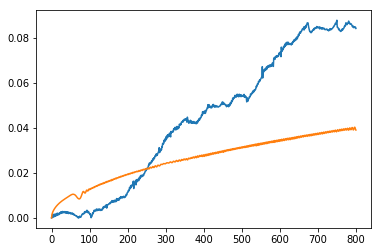

In [7]:
plt.plot(errors)
#plt.plot(sampled_yaw)
plt.plot(3 * yaw_std)

In [8]:
yaw_std

array([0.   , 0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.005, 0.005, 0.004, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005,

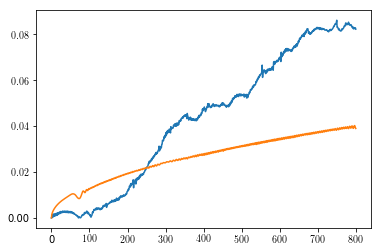

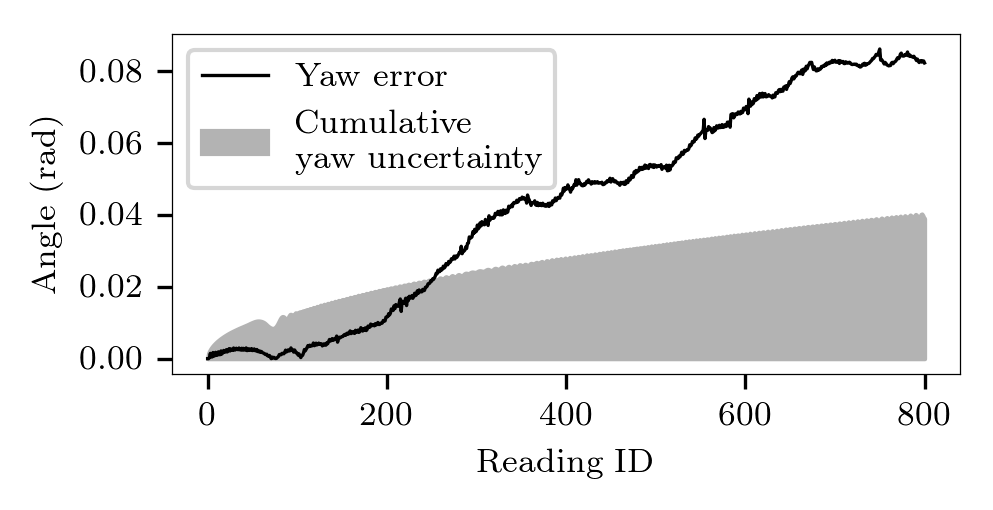

In [9]:
set_matplotlibrc()

fig, ax = plt.subplots()
fig.set_size_inches((3.413, 1.8))
fig.set_dpi(300)
ax.plot(errors, label='Yaw error', color='black', linewidth=0.8)
ax.fill_between(range(len(errors)), [0.0] * len(errors), 3*yaw_std, label='Cumulative \n yaw uncertainty', color='0.7')
ax.set_xlabel('Reading ID')
ax.set_ylabel('Angle (rad)')

plt.legend()
plt.tight_layout()
plt.savefig('/home/dlandry/yaw-error.pdf')
plt.show()